In [1]:
# All users: try this first
# ! conda install umap

# ! conda install plotly

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# data partition
from math import ceil

from sklearn.metrics import pairwise_distances

# import the algorithm
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.impute import KNNImputer

from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OrdinalEncoder

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram #centroids 

from sklearn.preprocessing import MinMaxScaler


from kmodes.kprototypes import KPrototypes
# Import module for k-protoype cluster
from kmodes.kmodes import KModes
# Import module for data visualization
from plotnine import *
import plotnine

# Use the theme of ggplot
plt.style.use('ggplot')


import umap
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

In [3]:
df=pd.read_sas('a2z_insurance.sas7bdat')
df.head()

CustID  FirstPolYear  BirthYear             EducDeg  MonthSal  GeoLivArea  \
0     1.0        1985.0     1982.0  b'2 - High School'    2177.0         1.0   
1     2.0        1981.0     1995.0  b'2 - High School'     677.0         4.0   
2     3.0        1991.0     1970.0        b'1 - Basic'    2277.0         3.0   
3     4.0        1990.0     1981.0      b'3 - BSc/MSc'    1099.0         4.0   
4     5.0        1986.0     1973.0      b'3 - BSc/MSc'    1763.0         4.0   

   Children  CustMonVal  ClaimsRate  PremMotor  PremHousehold  PremHealth  \
0       1.0      380.97        0.39     375.85          79.45      146.36   
1       1.0     -131.13        1.12      77.46         416.20      116.69   
2       0.0      504.67        0.28     206.15         224.50      124.58   
3       1.0      -16.99        0.99     182.48          43.35      311.17   
4       1.0       35.23        0.90     338.62          47.80      182.59   

   PremLife  PremWork  
0     47.01     16.89  
1    194.48    106.13  
2     86.35     99.02  
3     35.34     28.34  
4     18.78     41.45

In [4]:
CustID=df['CustID']
df.drop('CustID',axis=1,inplace=True)

In [5]:
CustID[CustID.duplicated()] #There is no repeated CustomerID

Series([], Name: CustID, dtype: float64)

In [6]:
df.shape

(10296, 13)

In [7]:
df.columns

Index(['FirstPolYear', 'BirthYear', 'EducDeg', 'MonthSal', 'GeoLivArea',
       'Children', 'CustMonVal', 'ClaimsRate', 'PremMotor', 'PremHousehold',
       'PremHealth', 'PremLife', 'PremWork'],
      dtype='object')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10296 entries, 0 to 10295
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   FirstPolYear   10266 non-null  float64
 1   BirthYear      10279 non-null  float64
 2   EducDeg        10279 non-null  object 
 3   MonthSal       10260 non-null  float64
 4   GeoLivArea     10295 non-null  float64
 5   Children       10275 non-null  float64
 6   CustMonVal     10296 non-null  float64
 7   ClaimsRate     10296 non-null  float64
 8   PremMotor      10262 non-null  float64
 9   PremHousehold  10296 non-null  float64
 10  PremHealth     10253 non-null  float64
 11  PremLife       10192 non-null  float64
 12  PremWork       10210 non-null  float64
dtypes: float64(12), object(1)
memory usage: 1.0+ MB


In [9]:
df['GeoLivArea']=df['GeoLivArea'].astype(object)
df['Children']=df['Children'].astype(object)

In [10]:
df.isna().sum()

FirstPolYear      30
BirthYear         17
EducDeg           17
MonthSal          36
GeoLivArea         1
Children          21
CustMonVal         0
ClaimsRate         0
PremMotor         34
PremHousehold      0
PremHealth        43
PremLife         104
PremWork          86
dtype: int64

In [11]:
metric_features=['FirstPolYear', 'BirthYear', 'MonthSal',
        'CustMonVal', 'ClaimsRate', 'PremMotor',
       'PremHousehold', 'PremHealth', 'PremLife', 'PremWork']
non_metric_features = ['EducDeg','GeoLivArea', 'Children']

In [12]:
df[metric_features].describe().T

count         mean          std        min      25%      50%  \
FirstPolYear   10266.0  1991.062634   511.267913    1974.00  1980.00  1986.00   
BirthYear      10279.0  1968.007783    19.709476    1028.00  1953.00  1968.00   
MonthSal       10260.0  2506.667057  1157.449634     333.00  1706.00  2501.50   
CustMonVal     10296.0   177.892605  1945.811505 -165680.42    -9.44   186.87   
ClaimsRate     10296.0     0.742772     2.916964       0.00     0.39     0.72   
PremMotor      10262.0   300.470252   211.914997      -4.11   190.59   298.61   
PremHousehold  10296.0   210.431192   352.595984     -75.00    49.45   132.80   
PremHealth     10253.0   171.580833   296.405976      -2.11   111.80   162.81   
PremLife       10192.0    41.855782    47.480632      -7.00     9.89    25.56   
PremWork       10210.0    41.277514    51.513572     -12.00    10.67    25.67   

                     75%       max  
FirstPolYear   1992.0000  53784.00  
BirthYear      1983.0000   2001.00  
MonthSal       3290.2500  55215.00  
CustMonVal      399.7775  11875.89  
ClaimsRate        0.9800    256.20  
PremMotor       408.3000  11604.42  
PremHousehold   290.0500  25048.80  
PremHealth      219.8200  28272.00  
PremLife         57.7900    398.30  
PremWork         56.7900   1988.70

In [13]:
df[non_metric_features].describe().T

count unique             top    freq
EducDeg       10279      4  b'3 - BSc/MSc'    4799
GeoLivArea  10295.0    4.0             4.0  4145.0
Children    10275.0    2.0             1.0  7262.0

In [14]:
df[df.isna().any(axis=1)]

FirstPolYear  BirthYear             EducDeg  MonthSal GeoLivArea  \
21           1977.0     1958.0  b'2 - High School'       NaN        3.0   
68           1983.0     1977.0  b'2 - High School'    1399.0        4.0   
138          1979.0     1976.0  b'2 - High School'    2538.0        2.0   
143          1996.0     1990.0      b'3 - BSc/MSc'       NaN        4.0   
184          1993.0     1984.0  b'2 - High School'    2419.0        4.0   
...             ...        ...                 ...       ...        ...   
10010           NaN     1947.0  b'2 - High School'    3959.0        2.0   
10057        1983.0     1980.0  b'2 - High School'    1569.0        4.0   
10142        1986.0     1985.0      b'3 - BSc/MSc'    1652.0        3.0   
10284        1980.0     1987.0      b'3 - BSc/MSc'    1504.0        4.0   
10285        1985.0     1948.0      b'3 - BSc/MSc'    3878.0        4.0   

      Children  CustMonVal  ClaimsRate  PremMotor  PremHousehold  PremHealth  \
21         1.0      111.37        0.80     407.52         111.70      100.13   
68         1.0      476.65        0.33     330.73         186.70      211.15   
138        1.0      149.59        0.69     194.26         305.60         NaN   
143        1.0      -42.45        1.02     146.36         353.95      220.04   
184        1.0      -62.23        1.07        NaN         253.95      230.60   
...        ...         ...         ...        ...            ...         ...   
10010      NaN     -128.24        1.14     177.81         153.35      311.28   
10057      1.0      222.60        0.55     235.60         211.15         NaN   
10142      1.0       55.67        0.88     257.05          94.45      308.39   
10284      1.0       -1.55        0.96     390.63          29.45      179.70   
10285      1.0      -57.45        1.04     269.05         217.25      219.93   

       PremLife  PremWork  
21        24.67     30.34  
68          NaN     15.78  
138       37.34     17.67  
143      121.80     42.01  
184        5.89     43.12  
...         ...       ...  
10010     67.79     35.45  
10057     32.34     68.79  
10142       NaN     13.78  
10284     -6.00       NaN  
10285     32.45       NaN  

[309 rows x 13 columns]

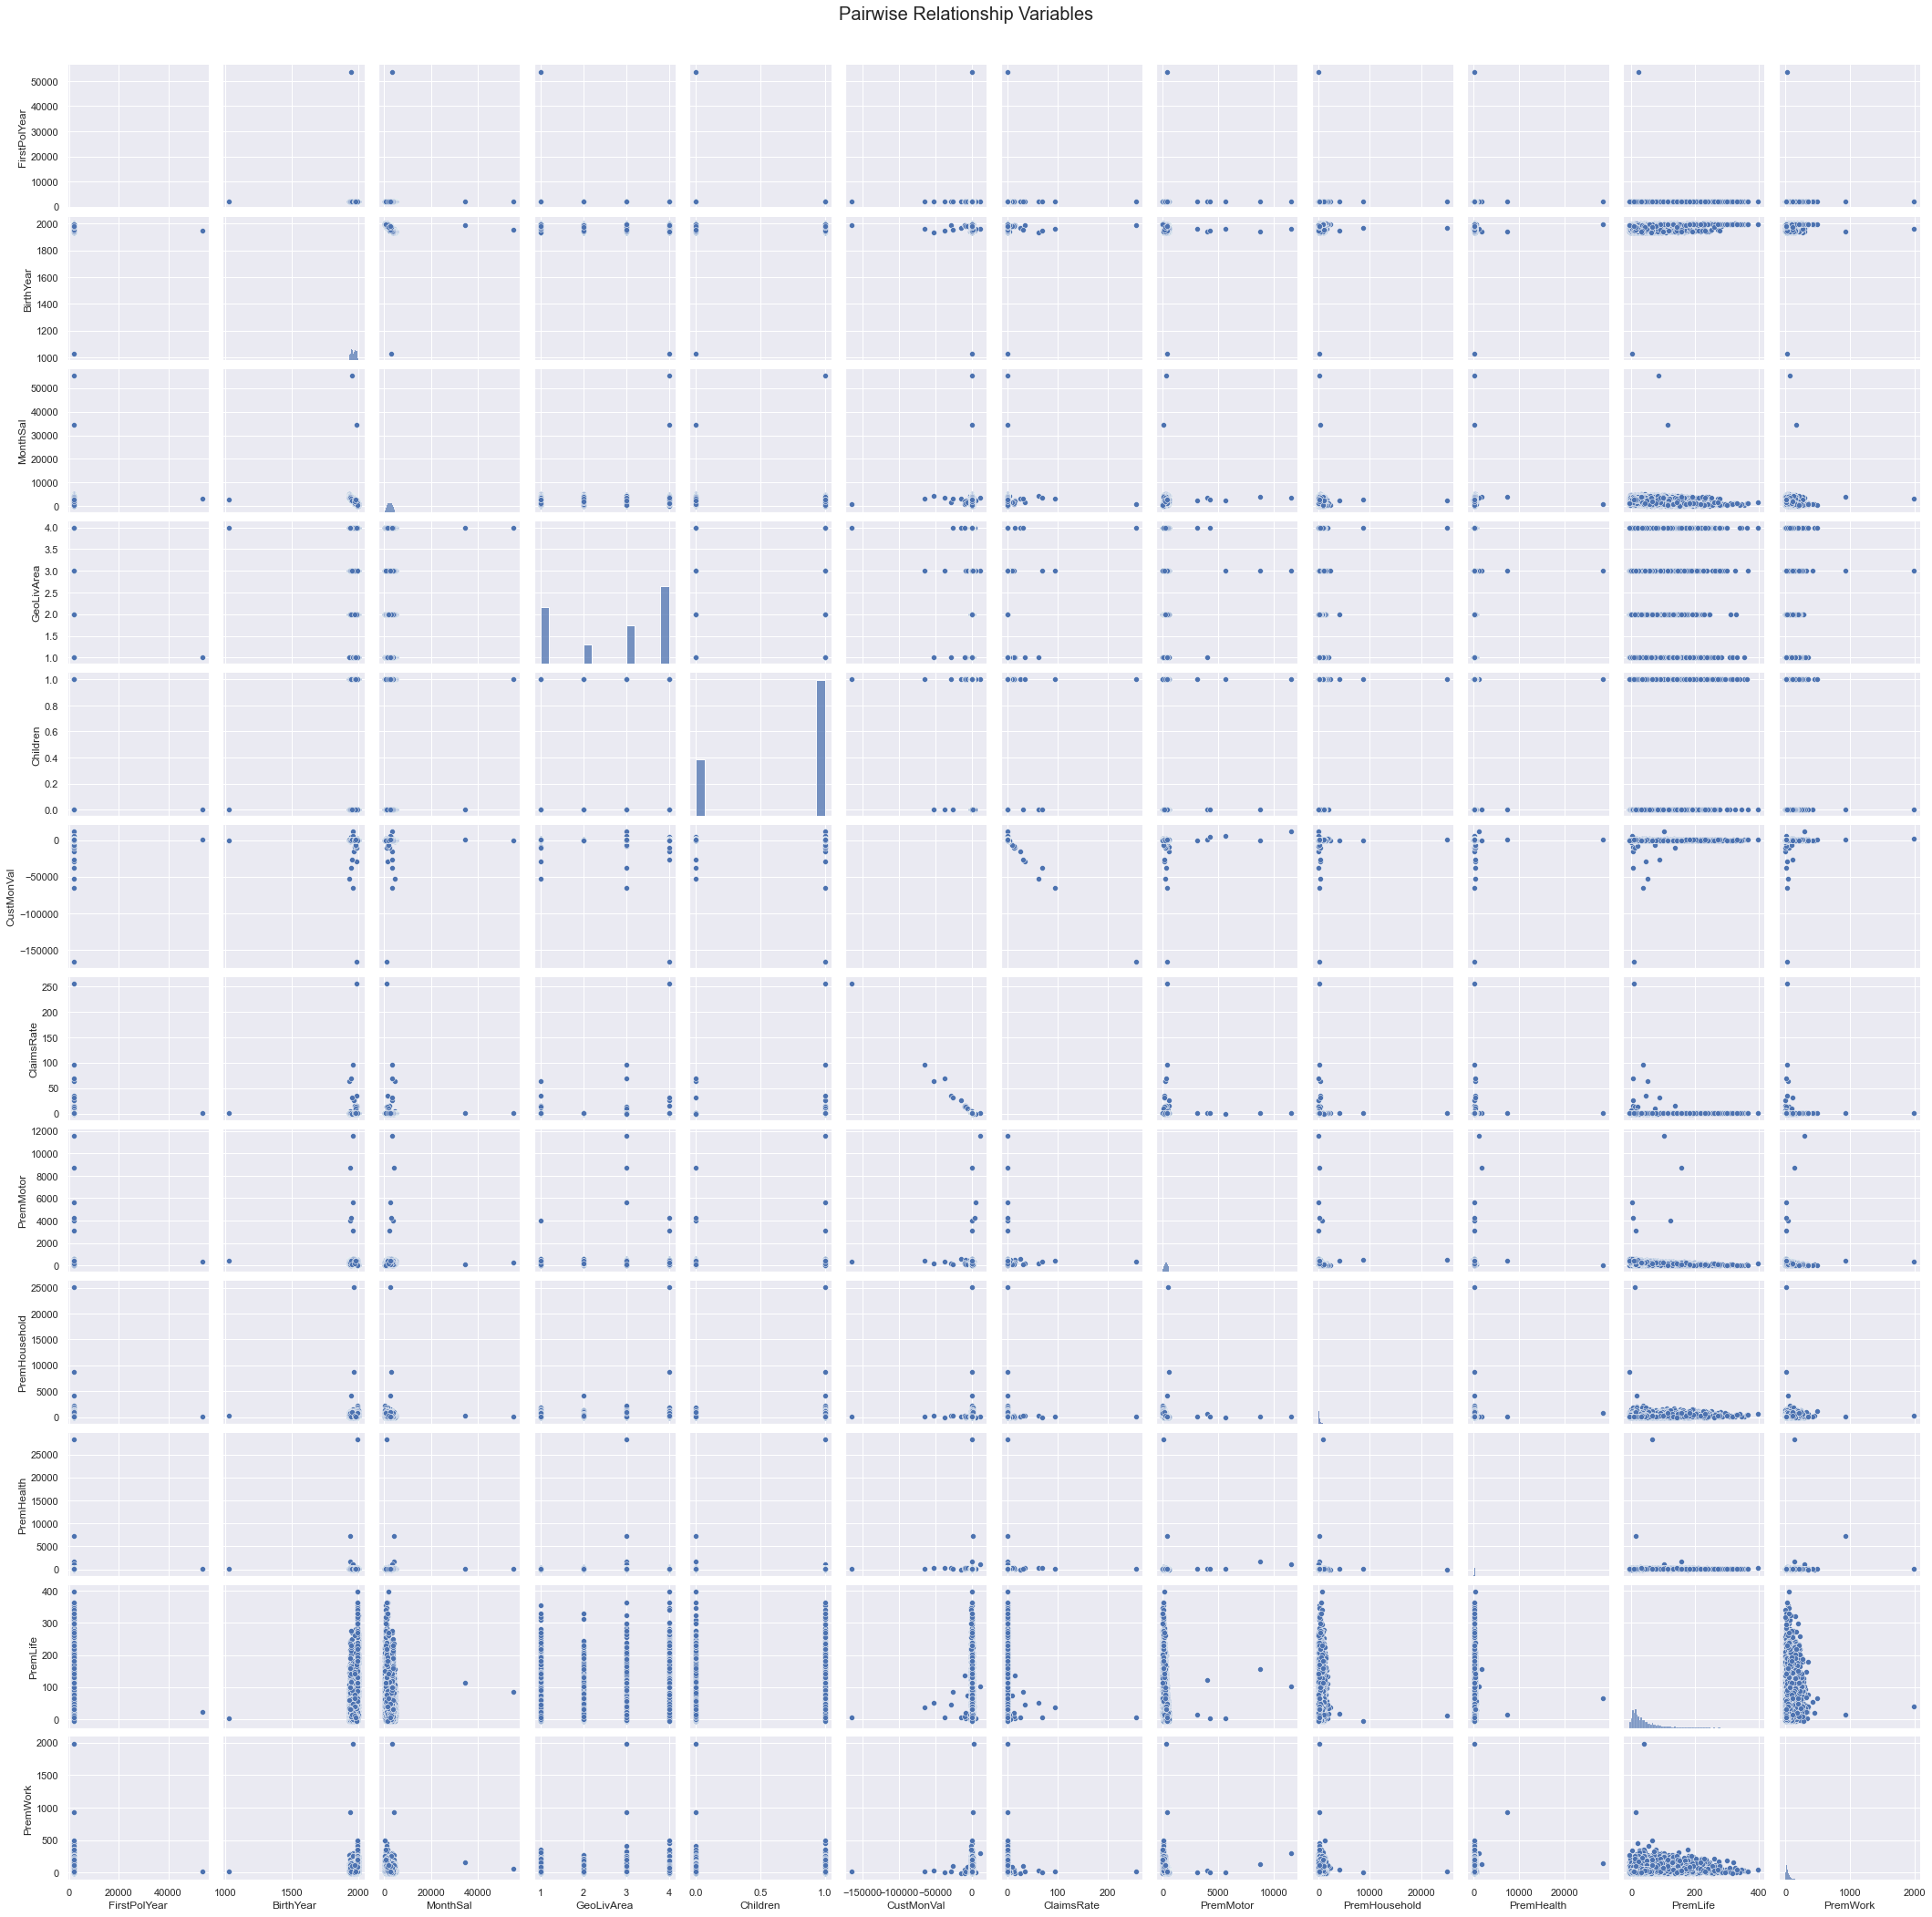

In [15]:
# Pairwise Relationship of Numerical Variables
sns.set()

# Setting pairplot
sns.pairplot(df )#diag_kind="hist"

# Layout
plt.subplots_adjust(top=0.95)
plt.suptitle("Pairwise Relationship Variables", fontsize=20)

plt.show()

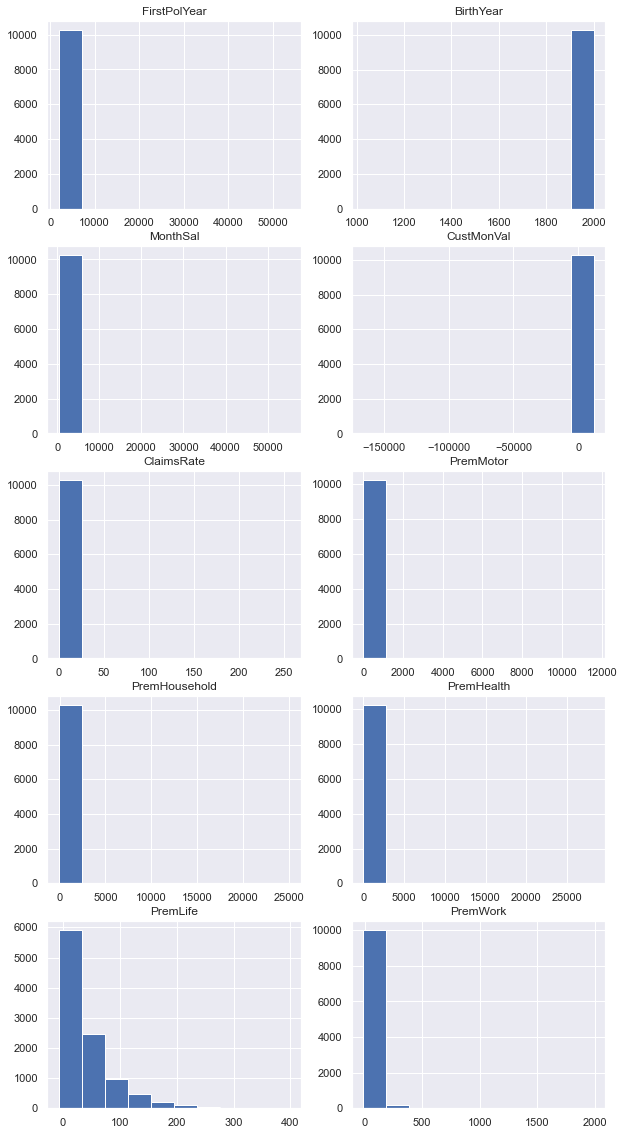

In [16]:
# All Numeric Variables' Histograms in one figure
sns.set()

# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(5, ceil(len(metric_features) / 5), figsize=(10, 20))

# Plot data
# Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
for ax, feat in zip(axes.flatten(), metric_features): # Notice the zip() function and flatten() method
    # CODE HERE (extra: set each axis title as the feature name)
    ax.hist(df[feat])
    ax.set_title(feat)

    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Histograms"

# plt.suptitle(title)

plt.show()

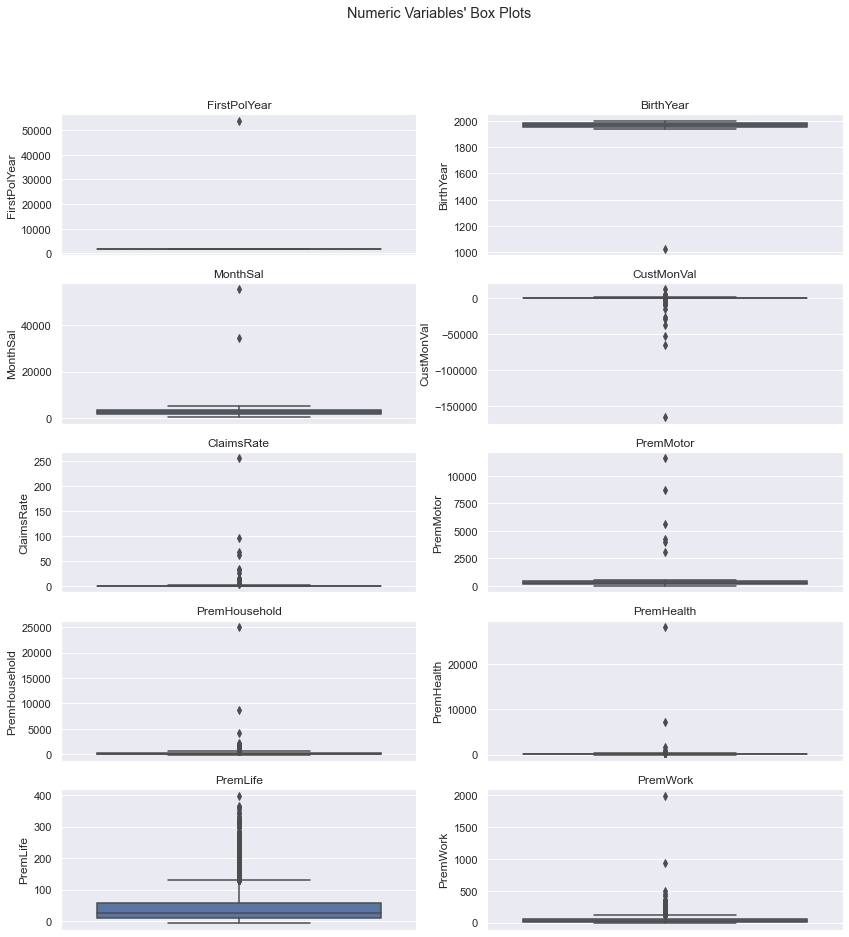

In [17]:
# All Numeric Variables' Box Plots in one figure
sns.set()

# Prepare figure. Create individual axes where each box plot will be placed
fig, axes = plt.subplots(5, ceil(len(metric_features) / 5), figsize=(14, 15))

# Plot data
# Iterate across axes objects and associate each box plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), metric_features): # Notice the zip() function and flatten() method
    # CODE HERE
    sns.boxplot(y=df[feat] , ax=ax)
    ax.set_title(feat)
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Box Plots"

plt.suptitle(title)

plt.show()

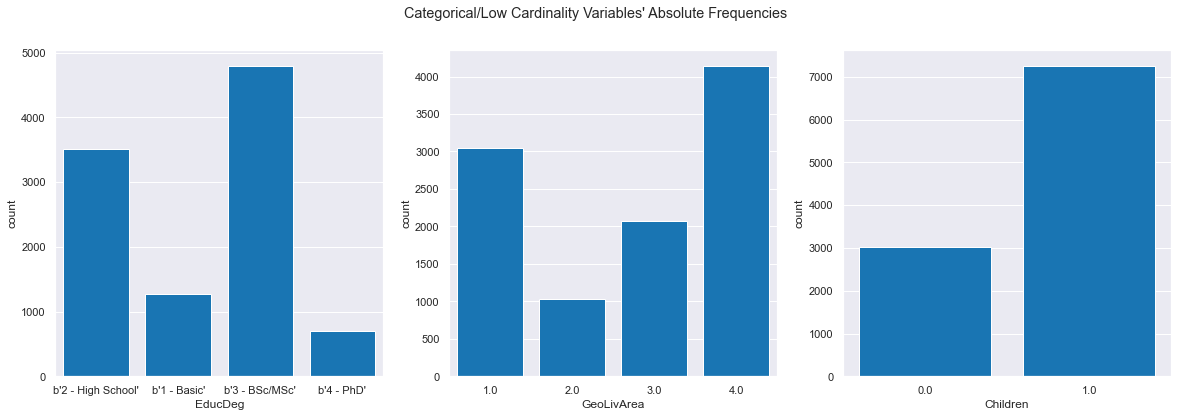

In [18]:
# All Non-Metric Variables' Absolute Frequencies
sns.set()

# Prepare figure. Create individual axes where each bar plot will be placed
fig, axes = plt.subplots(1, len(non_metric_features) , figsize=(20, 6))

# Plot data
# Iterate across axes objects and associate each bar plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), non_metric_features): # Notice the zip() function and flatten() method
    sns.countplot(df[feat].astype(object), ax=ax, color='#007acc')

title = "Categorical/Low Cardinality Variables' Absolute Frequencies"
plt.suptitle(title)

plt.show()

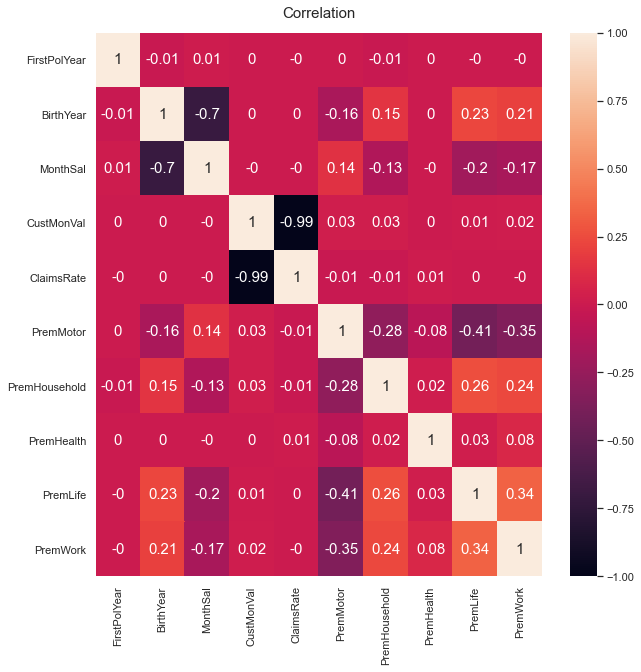

In [19]:

plt.figure(figsize=(10, 10))
heatmap = sns.heatmap(df.corr().round(2), vmin=-1, vmax=1, annot=True, annot_kws={'size': 15})
heatmap.set_title('Correlation', fontdict={'fontsize':15}, pad=15);

Create a df without rows with NaN values

In [20]:
# print(df)
is_NaN = df. isnull()
row_has_NaN = is_NaN. any(axis=1)
rows_with_NaN = df[row_has_NaN]
df_noNaN=df[~row_has_NaN]
print(len(rows_with_NaN),len(rows_with_NaN)/len(df)*100)
print(len(df_noNaN))

309 3.0011655011655014
9987


## Z-Score

In [21]:
count=0
for feature in df[metric_features].columns:
    zscore=pd.Series(df[feature] - df[feature].mean() ) / df[feature].std()
#     print(zscore[zscore>3])
    count+=(len(zscore[zscore>3])+len(zscore[zscore<-3]))
    print(feature,len(zscore[zscore>3])+len(zscore[zscore<-3]),(len(zscore[zscore>3])+len(zscore[zscore<-3]))/len(df)*100)
print()
print(count/len(df)*100)

FirstPolYear 1 0.009712509712509712
BirthYear 1 0.009712509712509712
MonthSal 2 0.019425019425019424
CustMonVal 13 0.12626262626262627
ClaimsRate 12 0.11655011655011654
PremMotor 6 0.05827505827505827
PremHousehold 36 0.34965034965034963
PremHealth 3 0.029137529137529136
PremLife 210 2.0396270396270397
PremWork 159 1.5442890442890442

4.302641802641802


In [22]:
zscore

0       -0.473419
1        1.258940
2        1.120918
3       -0.251148
4        0.003348
           ...   
10291   -0.514379
10292    1.239527
10293   -0.706368
10294    1.390556
10295   -0.551069
Name: PremWork, Length: 10296, dtype: float64

In [23]:
count=0
for feature in df_noNaN[metric_features].columns:
    zscore=pd.Series(df_noNaN[feature] - df_noNaN[feature].mean() ) / df_noNaN[feature].std()
    df_noNaN["zscore"]=(df_noNaN[feature] - df_noNaN[feature].mean() ) / df_noNaN[feature].std()
#     print(zscore[zscore>3])
    count+=(len(zscore[zscore>3])+len(zscore[zscore<-3]))
    df_noNaN["zscore_outliers"]=df_noNaN["zscore"].apply(lambda x: -1 if ((x>3) & (x<-3)) else 1)
    #print(feature,len(zscore[zscore>3])+len(zscore[zscore<-3]),(len(zscore[zscore>3])+len(zscore[zscore<-3]))/len(df)*100)
print()
print(count/len(df_noNaN)*100)


4.345649344147392


## LOF

In [24]:
##To review


#initialise the algorithm
lof = LocalOutlierFactor(n_neighbors = 20)
#fit it to the training data, since we don't use it for novelty than
# this is fine
y_pred = lof.fit_predict(df_noNaN[metric_features])
#extract the predictions as strings
df_noNaN["lof_outliers"] = y_pred.astype(str)
#print the number of outliers relative to non-outliers
print(df_noNaN["lof_outliers"].value_counts())
#extract the outlier scores
# df_noNaN["lof_scores"] = lof.negative_outlier_factor_
#print(len(df_noNaN[df_noNaN["iso_forest_outliers"]=="-1"])/len(df)*100)

1     9894
-1      93
Name: lof_outliers, dtype: int64


In [25]:
len(df.columns)

13

## Isolation Forest

In [26]:
isf = IsolationForest(n_estimators = 100, random_state = 42, contamination = 0.02)
#use fit_predict on the data as we are using all the data
preds = isf.fit_predict(df_noNaN[metric_features])
#extract outliers from the data
df_noNaN["iso_forest_outliers"] = preds
df_noNaN["iso_forest_outliers"] = df_noNaN["iso_forest_outliers"].astype(str)
#extract the scores from the data in terms of strength of outlier
df_noNaN["iso_forest_scores"] = isf.decision_function(df_noNaN[metric_features])#print how many outliers the data suggests
print(df_noNaN["iso_forest_outliers"].value_counts())# Out:
print(len(df_noNaN[df_noNaN["iso_forest_outliers"]=="-1"])/len(df)*100)

1     9787
-1     200
Name: iso_forest_outliers, dtype: int64
1.9425019425019423


In [27]:
# # Pairwise Relationship of Numerical Variables
# sns.set()

# # Setting pairplot
# sns.pairplot(df_noNaN, diag_kind="hist",hue="iso_forest_outliers")

# # Layout
# plt.subplots_adjust(top=0.95)
# plt.suptitle("Pairwise Relationship of Numerical Variables", fontsize=20)

# plt.show()

## DBScan Outlier Detection

In [28]:
#import the algorithm

#initiate the algorithm
#set the distance to 20, and min_samples as 5
outlier_detection = DBSCAN(eps = 40, metric = "euclidean", min_samples = 10, n_jobs = -1)
#fit_predict the algorithm to the existing data
clusters = outlier_detection.fit_predict(df_noNaN[metric_features])
#extract the labels from the algorithm
df_noNaN["dbscan_outliers"] = clusters
#label all others as inliers 
df_noNaN["dbscan_outliers"] = df_noNaN["dbscan_outliers"].apply(lambda x: str(1) if x>-1 else str(-1))
#print the vaue counts
print(df_noNaN["dbscan_outliers"].value_counts())

-1    9987
Name: dbscan_outliers, dtype: int64


### NOTE: THERE ARE NO CLEAR CLUSTERS , THE DATA IS VERY SPARSE 

In [29]:
#extract the sum of the outlier count
df_noNaN['outliers_sum'] = (df_noNaN['iso_forest_outliers'].astype(int)+
                           df_noNaN['lof_outliers'].astype(int)+
                           df_noNaN['zscore_outliers'].astype(int))
#print the value counts for eacdf_noNaNh scale
print(df_noNaN["outliers_sum"].value_counts())

 3    9720
 1     241
-1      26
Name: outliers_sum, dtype: int64


#### WITH ALL THESE 3 METHODS , THERE WERE 29 OBSERVATIONS HAVE CONSIDERES AS OUTLIERS FOR AT LEAST 2 METHODS

In [30]:
df_noNaN[['iso_forest_outliers','lof_outliers','zscore_outliers','outliers_sum']].loc[df_noNaN['outliers_sum']==-1]

iso_forest_outliers lof_outliers  zscore_outliers  outliers_sum
51                     -1           -1                1            -1
112                    -1           -1                1            -1
135                    -1           -1                1            -1
655                    -1           -1                1            -1
675                    -1           -1                1            -1
793                    -1           -1                1            -1
1069                   -1           -1                1            -1
1745                   -1           -1                1            -1
2323                   -1           -1                1            -1
2887                   -1           -1                1            -1
4373                   -1           -1                1            -1
5084                   -1           -1                1            -1
5211                   -1           -1                1            -1
5293                   -1           -1                1            -1
6270                   -1           -1                1            -1
6742                   -1           -1                1            -1
7961                   -1           -1                1            -1
8366                   -1           -1                1            -1
8425                   -1           -1                1            -1
8667                   -1           -1                1            -1
8741                   -1           -1                1            -1
9149                   -1           -1                1            -1
9235                   -1           -1                1            -1
9390                   -1           -1                1            -1
9954                   -1           -1                1            -1
10292                  -1           -1                1            -1

In [31]:
outliers_index=df_noNaN[['iso_forest_outliers','lof_outliers','zscore_outliers','outliers_sum']].loc[df_noNaN['outliers_sum']==-1].index
outliers_index=np.array(outliers_index)

In [32]:
len(outliers_index)

26

In [33]:
df_outliers=df.iloc[outliers_index]

In [34]:
df_noNaN_wihthout_outliers = df_noNaN[~df_noNaN.index.isin(outliers_index)]

In [35]:
df_num=df[['FirstPolYear', 'BirthYear', 'MonthSal',
        'CustMonVal', 'ClaimsRate', 'PremMotor',
       'PremHousehold', 'PremHealth', 'PremLife', 'PremWork']]

In [36]:
df_cat=df[['EducDeg','GeoLivArea', 'Children']]

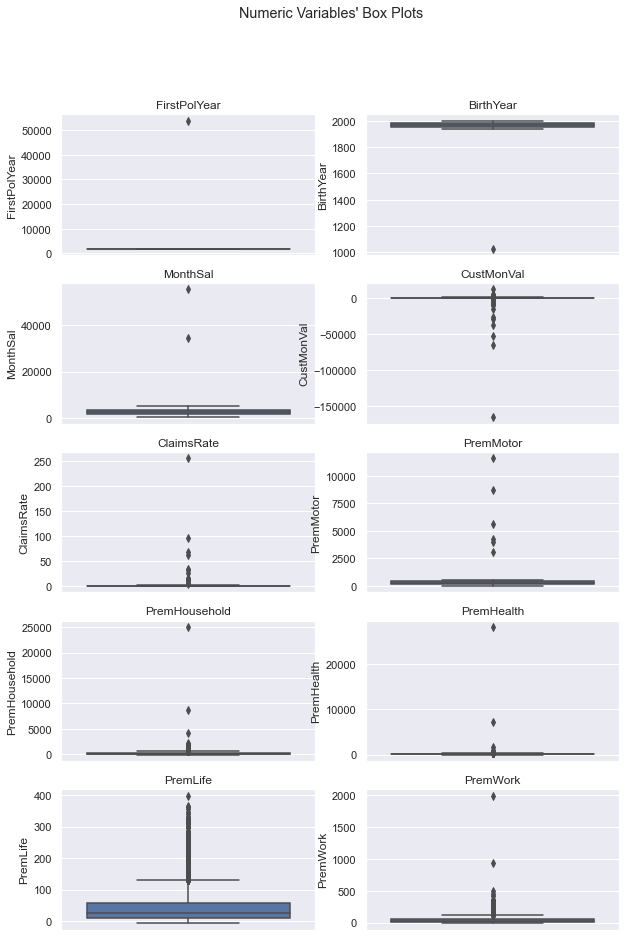

In [37]:
# All Numeric Variables' Box Plots in one figure
sns.set()

# Prepare figure. Create individual axes where each box plot will be placed
fig, axes = plt.subplots(5, ceil(len(metric_features) / 5), figsize=(10, 15))

# Plot data
# Iterate across axes objects and associate each box plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), metric_features): # Notice the zip() function and flatten() method
    # CODE HERE
    sns.boxplot(y=df_noNaN[feat] , ax=ax)
    ax.set_title(feat)
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Box Plots"

plt.suptitle(title)

plt.show()

In [38]:
df_outliers=pd.concat([df_outliers,df_noNaN_wihthout_outliers[df_noNaN_wihthout_outliers['MonthSal']>20000]])
df_noNaN_wihthout_outliers=df_noNaN_wihthout_outliers[df_noNaN_wihthout_outliers['MonthSal']<20000]


df_outliers=pd.concat([df_outliers,df_noNaN_wihthout_outliers[df_noNaN_wihthout_outliers['PremHousehold']>2000]])
df_noNaN_wihthout_outliers=df_noNaN_wihthout_outliers[df_noNaN_wihthout_outliers['PremHousehold']<2000]

df_outliers=pd.concat([df_outliers,df_noNaN_wihthout_outliers[df_noNaN_wihthout_outliers['PremMotor']>2000]])
df_noNaN_wihthout_outliers=df_noNaN_wihthout_outliers[df_noNaN_wihthout_outliers['PremMotor']<2000]

df_outliers=pd.concat([df_outliers,df_noNaN_wihthout_outliers[df_noNaN_wihthout_outliers['CustMonVal']<-1000]])
df_noNaN_wihthout_outliers=df_noNaN_wihthout_outliers[df_noNaN_wihthout_outliers['CustMonVal']>-1000]

df_outliers=pd.concat([df_outliers,df_noNaN_wihthout_outliers[df_noNaN_wihthout_outliers['FirstPolYear']>2016]])
df_noNaN_wihthout_outliers=df_noNaN_wihthout_outliers[df_noNaN_wihthout_outliers['FirstPolYear']<2016]

df_outliers=pd.concat([df_outliers,df_noNaN_wihthout_outliers[df_noNaN_wihthout_outliers['BirthYear']<1900]])
df_noNaN_wihthout_outliers=df_noNaN_wihthout_outliers[df_noNaN_wihthout_outliers['BirthYear']>1900]


In [39]:
len(df_outliers)

45

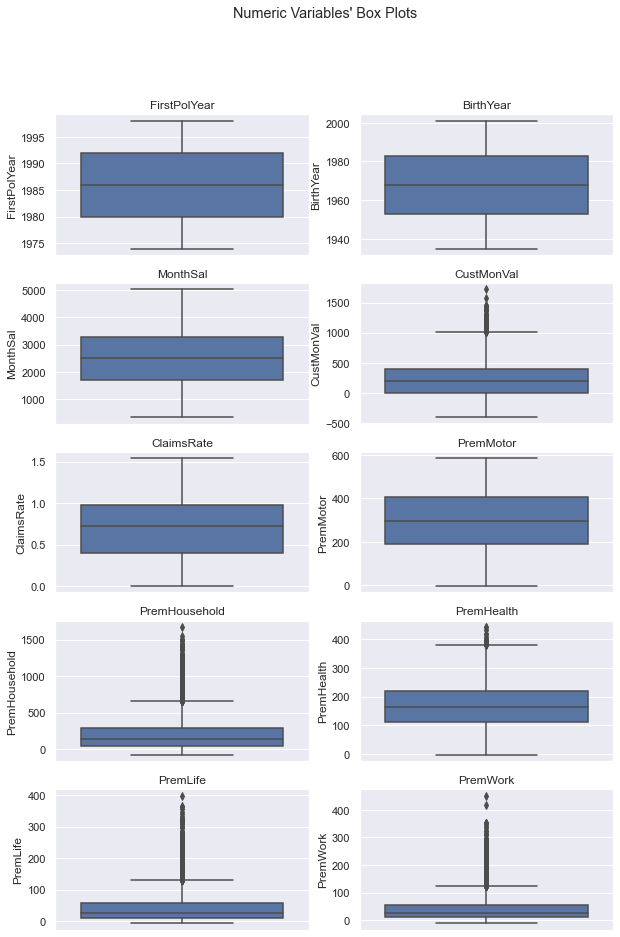

In [40]:
# All Numeric Variables' Box Plots in one figure
sns.set()

# Prepare figure. Create individual axes where each box plot will be placed
fig, axes = plt.subplots(5, ceil(len(metric_features) / 5), figsize=(10, 15))

# Plot data
# Iterate across axes objects and associate each box plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), metric_features): # Notice the zip() function and flatten() method
    # CODE HERE
    sns.boxplot(y=df_noNaN_wihthout_outliers[feat] , ax=ax)
    ax.set_title(feat)
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Box Plots"

plt.suptitle(title)

plt.show()

## FillNA com KNN Inputer

In [41]:
df_toFill=pd.concat([df_noNaN_wihthout_outliers,rows_with_NaN]).sort_index()

In [42]:
imputer = IterativeImputer(ExtraTreesRegressor(n_estimators=10, random_state=0)).fit(df_toFill[metric_features])
filled_df = imputer.transform(df_toFill[metric_features])

In [43]:
filled_df=pd.DataFrame(filled_df, index=df_toFill[metric_features].index , columns=df_toFill[metric_features].columns)

In [44]:
filled_df=pd.concat([filled_df,df_toFill[['EducDeg','GeoLivArea', 'Children']]],axis=1)

In [45]:
filled_df.isna().sum()

FirstPolYear      0
BirthYear         0
MonthSal          0
CustMonVal        0
ClaimsRate        0
PremMotor         0
PremHousehold     0
PremHealth        0
PremLife          0
PremWork          0
EducDeg          17
GeoLivArea        1
Children         21
dtype: int64

In [46]:
dt_educdeg=DecisionTreeClassifier(random_state=0)
dt_geolivarea=DecisionTreeClassifier(random_state=0)
dt_children=DecisionTreeClassifier(random_state=0)

In [47]:
y_train=filled_df[~filled_df['EducDeg'].isna()]['EducDeg']
y_target=filled_df[filled_df['EducDeg'].isna()]['EducDeg']
X_train=filled_df[~filled_df['EducDeg'].isna()].drop(['EducDeg','GeoLivArea','Children'],axis=1)
X_target=filled_df[filled_df['EducDeg'].isna()].drop(['EducDeg','GeoLivArea','Children'],axis=1)

In [48]:
y_train=pd.DataFrame(y_train)
enc = OrdinalEncoder()
y_train=enc.fit_transform(y_train)
dt_educdeg.fit(X_train,y_train)
pred=dt_educdeg.predict(X_target)
pred=pred.astype(int)
pred_educdeg =[]
for idx in range(len(pred)):
    pred_educdeg.append(enc.categories_[0][pred[idx]])
pred_educdeg=pd.Series(pred_educdeg,name='EducDeg',index=y_target.index)

In [49]:
y_train=filled_df[~filled_df['GeoLivArea'].isna()]['GeoLivArea']
y_target=filled_df[filled_df['GeoLivArea'].isna()]['GeoLivArea']
X_train=filled_df[~filled_df['GeoLivArea'].isna()].drop(['EducDeg','GeoLivArea','Children'],axis=1)
X_target=filled_df[filled_df['GeoLivArea'].isna()].drop(['EducDeg','GeoLivArea','Children'],axis=1)

In [50]:
y_train=pd.DataFrame(y_train)
enc = OrdinalEncoder()
y_train=enc.fit_transform(y_train)
dt_educdeg.fit(X_train,y_train)
pred=dt_educdeg.predict(X_target)
pred=pred.astype(int)
pred_geolivarea =[]
for idx in range(len(pred)):
    pred_geolivarea.append(enc.categories_[0][pred[idx]])
pred_geolivarea=pd.Series(pred_geolivarea,name='GeoLivArea',index=y_target.index)

In [51]:
y_train=filled_df[~filled_df['Children'].isna()]['Children']
y_target=filled_df[filled_df['Children'].isna()]['Children']
X_train=filled_df[~filled_df['Children'].isna()].drop(['EducDeg','GeoLivArea','Children'],axis=1)
X_target=filled_df[filled_df['Children'].isna()].drop(['EducDeg','GeoLivArea','Children'],axis=1)

In [52]:
y_train=pd.DataFrame(y_train)
enc = OrdinalEncoder()
y_train=enc.fit_transform(y_train)
dt_educdeg.fit(X_train,y_train)
pred=dt_educdeg.predict(X_target)
pred=pred.astype(int)
pred_children =[]
for idx in range(len(pred)):
    pred_children.append(enc.categories_[0][pred[idx]])
pred_children=pd.Series(pred_children,name='Children',index=y_target.index)

In [53]:
filled_df['EducDeg'].loc[pred_educdeg.index]=pred_educdeg
filled_df['GeoLivArea'].loc[pred_geolivarea.index]=pred_geolivarea
filled_df['Children'].loc[pred_children.index]=pred_children

In [54]:
filled_df['EducDeg']=filled_df['EducDeg'].fillna(filled_df['EducDeg'].mode()[0])

In [55]:
filled_df.isna().sum()

FirstPolYear     0
BirthYear        0
MonthSal         0
CustMonVal       0
ClaimsRate       0
PremMotor        0
PremHousehold    0
PremHealth       0
PremLife         0
PremWork         0
EducDeg          0
GeoLivArea       0
Children         0
dtype: int64

## Clustering

## Clustering Premium Segmentation

In [56]:
premiumns_feat=['PremMotor','PremHousehold','PremHealth','PremLife','PremWork','CustMonVal']
premiums = filled_df[premiumns_feat]
premiums.head()

PremMotor  PremHousehold  PremHealth  PremLife  PremWork  CustMonVal
0     375.85          79.45      146.36     47.01     16.89      380.97
1      77.46         416.20      116.69    194.48    106.13     -131.13
2     206.15         224.50      124.58     86.35     99.02      504.67
3     182.48          43.35      311.17     35.34     28.34      -16.99
4     338.62          47.80      182.59     18.78     41.45       35.23

In [57]:
#check the correlation
premiums.corr()

PremMotor  PremHousehold  PremHealth  PremLife  PremWork  \
PremMotor       1.000000      -0.651009   -0.628857 -0.656279 -0.645496   
PremHousehold  -0.651009       1.000000    0.094113  0.416114  0.407929   
PremHealth     -0.628857       0.094113    1.000000  0.094232  0.093204   
PremLife       -0.656279       0.416114    0.094232  1.000000  0.382242   
PremWork       -0.645496       0.407929    0.093204  0.382242  1.000000   
CustMonVal     -0.060310       0.295846   -0.104554  0.031387  0.044744   

               CustMonVal  
PremMotor       -0.060310  
PremHousehold    0.295846  
PremHealth      -0.104554  
PremLife         0.031387  
PremWork         0.044744  
CustMonVal       1.000000

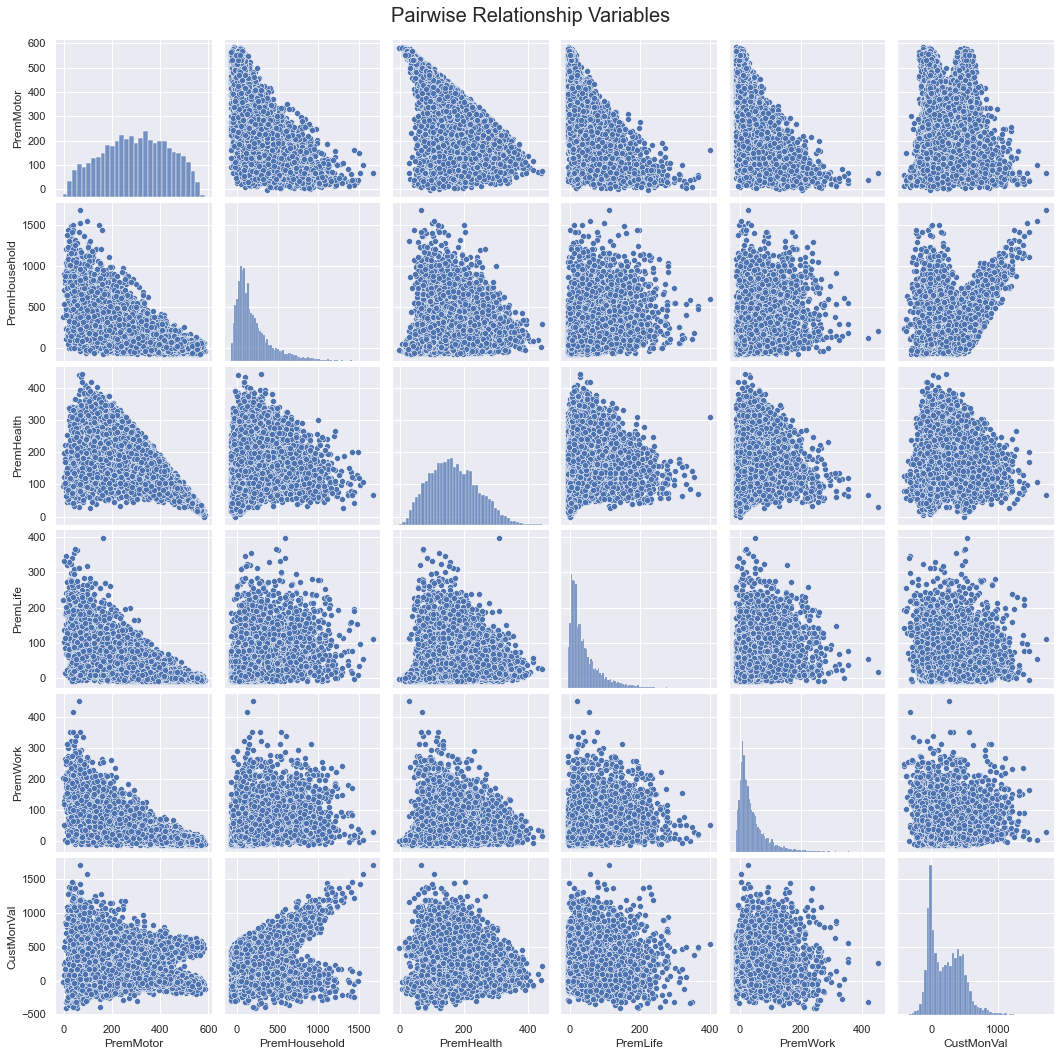

In [58]:
# # Pairwise Relationship of Numerical Variables
sns.set()

# # Setting pairplot
sns.pairplot(premiums,diag_kind="hist")

# # Layout
plt.subplots_adjust(top=0.95)
plt.suptitle("Pairwise Relationship Variables", fontsize=20)

plt.show()

In [59]:
#Scale the data
scaler_premium = MinMaxScaler().fit(premiums)
indices=premiums.index
scaled_premiums = scaler_premium.transform(premiums)

In [60]:
# Ex with K-Means

sse = []
n_clusters = 25

for k in range(1, n_clusters + 1):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(scaled_premiums)
    sse.append(kmeans.inertia_)

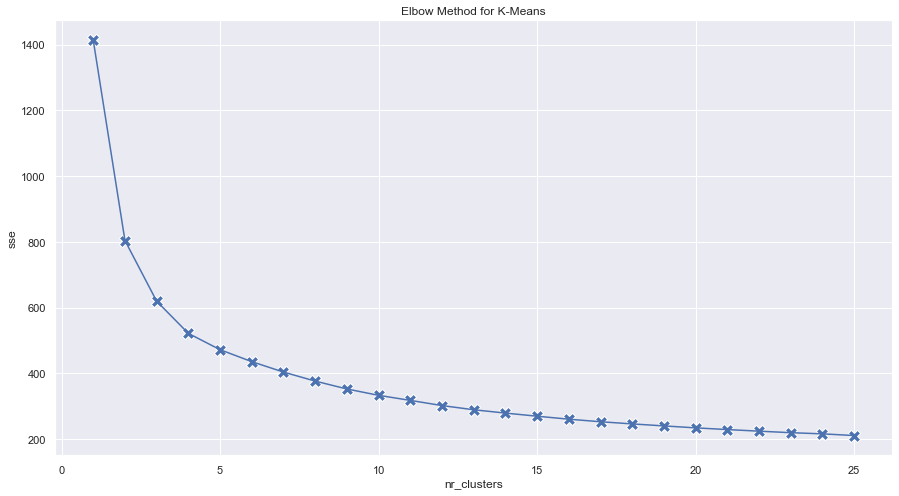

In [61]:
df_sse = pd.DataFrame({'nr_clusters': range(1, n_clusters + 1), 'sse': sse})

plt.figure(figsize = (15, 8))
sns.lineplot(data = df_sse, x = 'nr_clusters', y = 'sse')
sns.scatterplot(data = df_sse, x = 'nr_clusters', y = 'sse', marker = 'X', s = 150)
plt.title('Elbow Method for K-Means')
plt.show()

### Clustering k=10

In [62]:
k = 10
kmeans = KMeans(n_clusters=k, random_state=0).fit(scaled_premiums)
print(f"Total Error: {kmeans.inertia_}")

Total Error: 333.3734844186677


In [63]:
labels = kmeans.labels_
filled_df["premium_segmentation"] = labels

In [64]:
centroids = filled_df.groupby("premium_segmentation")[premiumns_feat].mean()

In [65]:
centroids = kmeans.cluster_centers_  
original_centroids = scaler_premium.inverse_transform(centroids) 

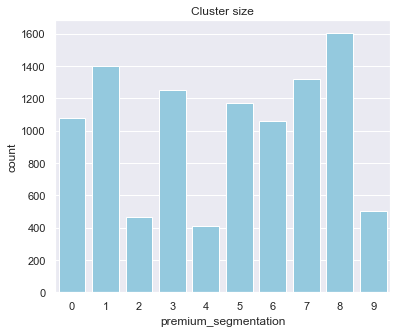

In [66]:
plt.figure(figsize = (6, 5))
sns.countplot(data=filled_df, x = 'premium_segmentation', color="skyblue")
plt.title("Cluster size")
plt.show()

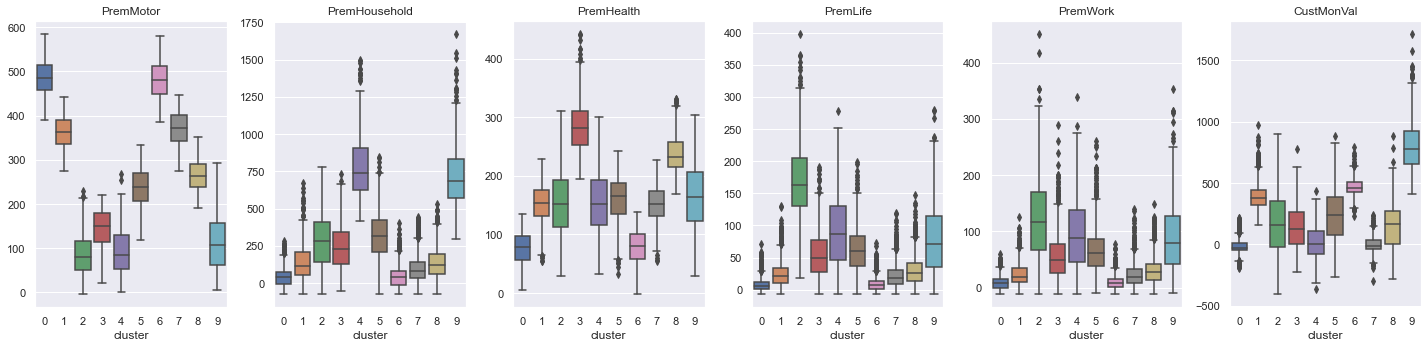

In [67]:
fig, ax = plt.subplots(nrows = 1, ncols = len(premiumns_feat), figsize = (20, 5))

for idx, c in enumerate(premiumns_feat):
    sns.boxplot(data = filled_df, x = 'premium_segmentation', y = c, ax = ax[idx])
    ax[idx].set_ylabel("")
    ax[idx].set_xlabel("cluster")
    ax[idx].set_title(c)
plt.tight_layout()
plt.show()

In [68]:
def outside_limit(df, label_col, label, sensitivity):
    feature_list = df_sem_norm.columns
    plot_list = []
    mean_overall_list = []
    mean_cluster_list = []
    dif_list=[]
    for i,varname in enumerate(feature_list):
    
   
        mean_overall = df[varname].mean()
        std_overall=  df[varname].std()
        n_overall= df[varname].shape[0]
        lower_limit = mean_overall - (mean_overall*sensitivity)
        upper_limit = mean_overall + (mean_overall*sensitivity)


        cluster_filter = df[label_col]==label
        pd_cluster = df[cluster_filter]
        mean_cluster = pd_cluster[varname].mean()


        #if mean_cluster <= lower_limit or mean_cluster >= upper_limit:
        plot_list.append(varname)
        mean_overall_std = mean_overall/mean_overall
        mean_cluster_std = mean_cluster/mean_overall-1
        mean_overall_list.append(mean_overall_std)
        mean_cluster_list.append(mean_cluster_std)
   
    mean_df = pd.DataFrame({'feature_list':plot_list,
                         'mean_overall_list':mean_overall_list,
                         'mean_cluster_list':mean_cluster_list})
    mean_df = mean_df.sort_values(by=['mean_cluster_list'], ascending=False)

    return mean_df





def plot_barchart_all_unique_features(df, label_col, label, ax, sensitivity):
  
    mean_df = outside_limit(df, label_col, label, sensitivity)
    mean_df_to_plot = mean_df.drop(['mean_overall_list'], axis=1)
    
    
  
    if len(mean_df.index) != 0:
        sns.barplot(y='feature_list', x='mean_cluster_list', data=mean_df_to_plot, palette=sns.cubehelix_palette(20, start=.5, rot=-.75, reverse=True), \
                alpha=0.75, dodge=True, ax=ax)

        for i,p in enumerate(ax.patches):
            ax.annotate("{:.02f}".format((p.get_width())), 
                  (1, p.get_y() + p.get_height() / 2.), xycoords=('axes fraction', 'data'),
                  ha='right', va='top', fontsize=10, color='black', rotation=0, 
                  xytext=(0, 0),
                  textcoords='offset pixels')
  
            ax.set_title('Unique Characteristics of Cluster ' + str(label))
            ax.set_xlabel('Standardized Mean')
            #x.axvline(x=1, color='k')

def plot_features_all_cluster(df, label_col, n_clusters, sensitivity):
    n_plot = n_clusters
    fig, ax = plt.subplots(n_plot, 1, figsize=(12, n_plot*6), sharex='col')
    ax= ax.ravel()
  
    label = np.arange(n_clusters)
    for i in label:
        plot_barchart_all_unique_features(df, label_col, label=i, ax=ax[i], sensitivity=sensitivity)
        ax[i].xaxis.set_tick_params(labelbottom=True)
    plt.tight_layout()

In [69]:
df_sem_norm=pd.DataFrame(scaled_premiums,columns=premiums.columns,index=indices)

In [70]:
df_features=pd.concat([df_sem_norm,filled_df["premium_segmentation"]],axis=1)

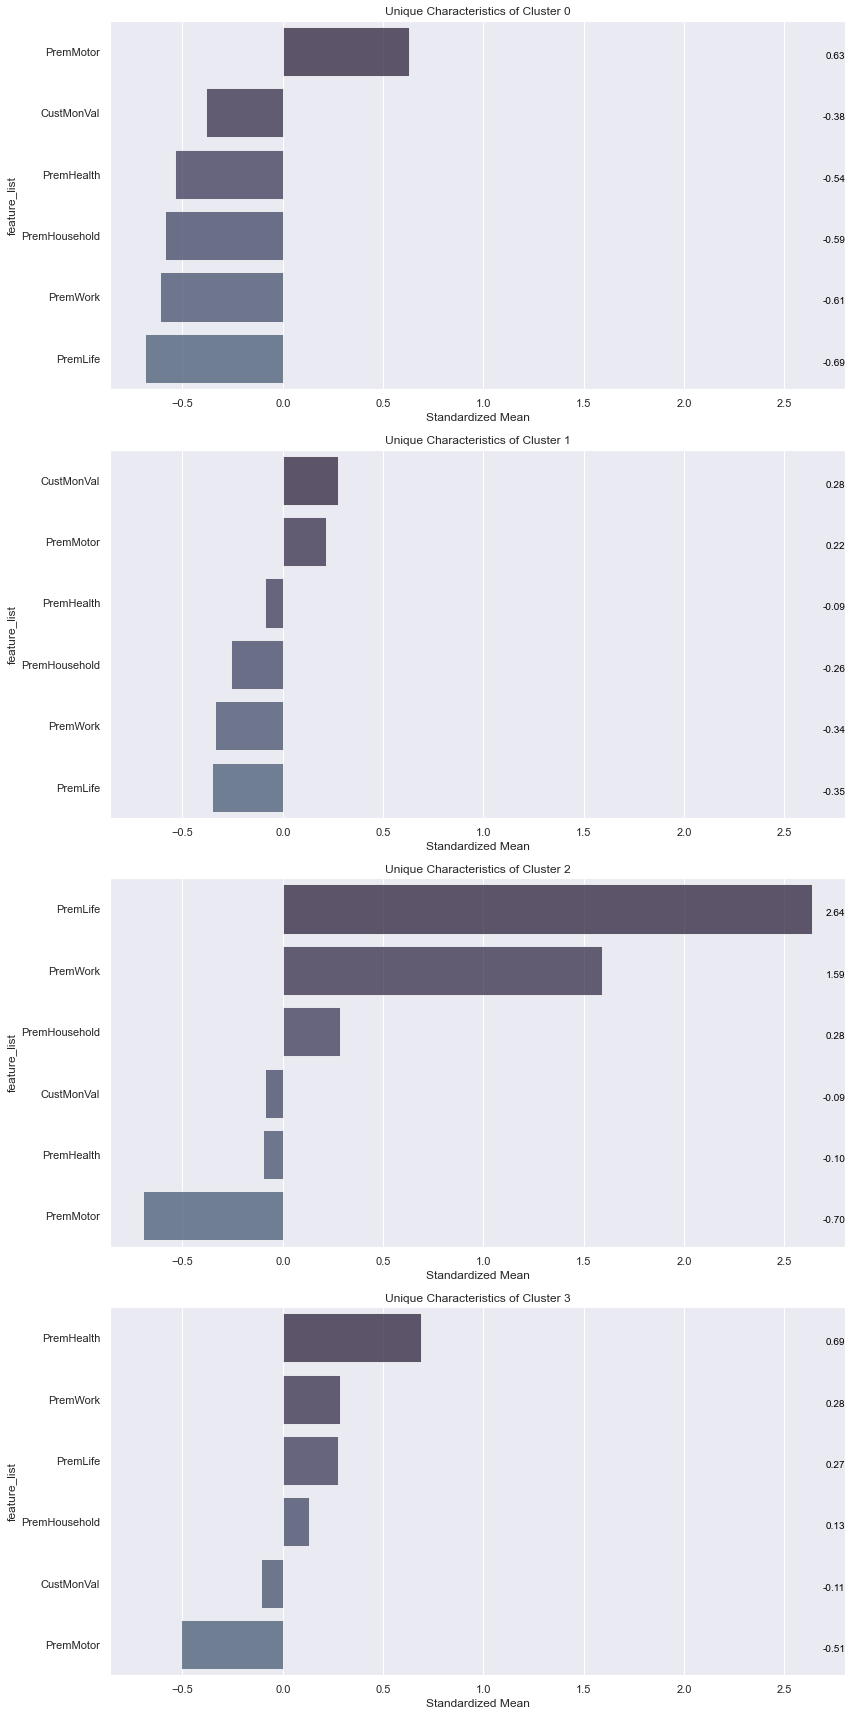

In [71]:
plot_features_all_cluster(df=df_features, label_col='premium_segmentation', n_clusters=4, sensitivity=0.001)

#### check out the same ting happened with children ( for socio demographic segmentation we have to take careful , and solve this problem

### Distribution of Living Area Amongst the clusters

<AxesSubplot:>

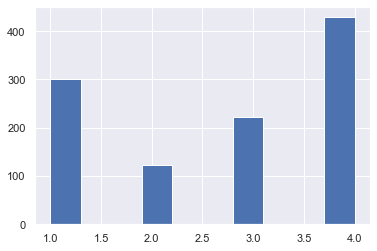

In [72]:
filled_df[filled_df['premium_segmentation']==0]['GeoLivArea'].hist()

<AxesSubplot:>

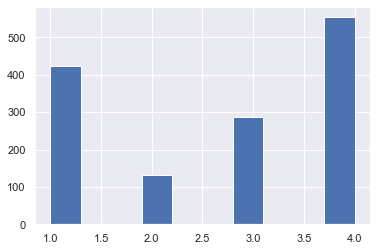

In [73]:
filled_df[filled_df['premium_segmentation']==1]['GeoLivArea'].hist()

<AxesSubplot:>

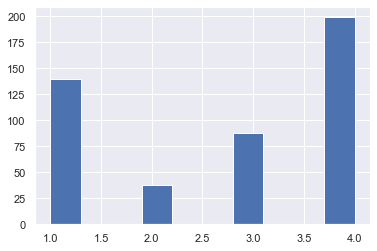

In [74]:
filled_df[filled_df['premium_segmentation']==2]['GeoLivArea'].hist()

<AxesSubplot:>

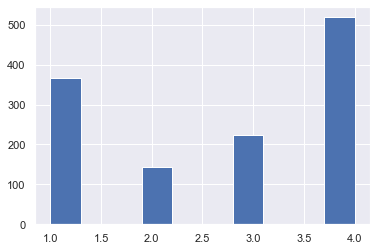

In [75]:
filled_df[filled_df['premium_segmentation']==3]['GeoLivArea'].hist()

### HIERARCHICAL CLUSTERING PREMIUMS

In [76]:
centroids=pd.DataFrame(centroids)

In [77]:
# Performing HC
hclust = AgglomerativeClustering(linkage='average', affinity='manhattan', n_clusters=5)
hc_labels = hclust.fit_predict(centroids) # CODE HERE
hc_labels

array([2, 4, 3, 0, 1, 0, 2, 4, 0, 1], dtype=int64)

In [78]:
# Computing SST
X = centroids.values
sst = np.sum(np.square(X - X.mean(axis=0)), axis=0)

# Computing SSW
ssw_iter = []
for i in np.unique(hc_labels):
    X_k = X[hc_labels == i]
    ssw_iter.append(np.sum(np.square(X_k - X_k.mean(axis=0)), axis=0))
ssw = np.sum(ssw_iter, axis=0)

# Computing SSB
ssb_iter = []
for i in np.unique(hc_labels):
    X_k = X[hc_labels == i]
    ssb_iter.append(X_k.shape[0] * np.square(X_k.mean(axis=0) - X.mean(axis=0)))
ssb = np.sum(ssb_iter, axis=0)

# Verifying the formula
np.round(sst) == np.round((ssw + ssb))

array([ True,  True,  True,  True,  True,  True])

In [79]:
def get_r2_hc(df, link_method, max_nclus, min_nclus=1, dist="euclidean"):
    """This function computes the R2 for a set of cluster solutions given by the application of a hierarchical method.
    The R2 is a measure of the homogenity of a cluster solution. It is based on SSt = SSw + SSb and R2 = SSb/SSt. 
    
    Parameters:
    df (DataFrame): Dataset to apply clustering
    link_method (str): either "ward", "complete", "average", "single"
    max_nclus (int): maximum number of clusters to compare the methods
    min_nclus (int): minimum number of clusters to compare the methods. Defaults to 1.
    dist (str): distance to use to compute the clustering solution. Must be a valid distance. Defaults to "euclidean".
    
    Returns:
    ndarray: R2 values for the range of cluster solutions
    """
    def get_ss(df):
        ss = np.sum(df.var() * (df.count() - 1)) # CODE HERE
        return ss  # return sum of sum of squares of each df variable
    
    sst = get_ss(df)  # get total sum of squares
    
    r2 = []  # where we will store the R2 metrics for each cluster solution
    
    for i in range(min_nclus, max_nclus+1):  # iterate over desired ncluster range
        cluster = AgglomerativeClustering(n_clusters=i, affinity=dist, linkage=link_method)
        
        #get cluster labels
        hclabels = cluster.fit_predict(df) 
        
        # concat df with labels
        df_concat = pd.concat((df, pd.Series(hclabels, name='labels')), axis=1)  
        
        # compute ssw for each cluster labels
        ssw_labels = df_concat.groupby(by='labels').apply(get_ss)  
        
        # Obtain SSB. Remember: SST = SSW + SSB
        ssb = sst - np.sum(ssw_labels) # CODE HERE SSB = SST - SSW
        
        # append the R2 of the given cluster solution
        r2.append(ssb / sst)# CODE HERE
        
    return np.array(r2)

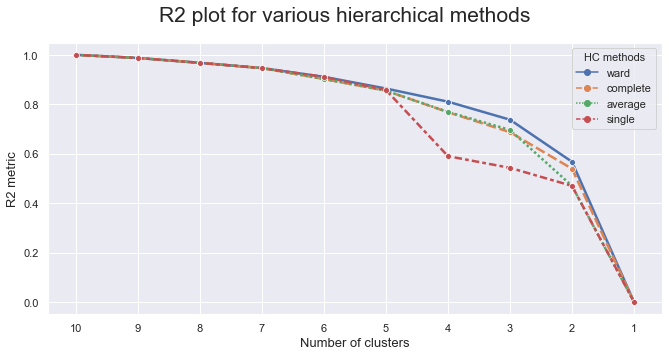

In [80]:
# Prepare input
hc_methods = ["ward", "complete", "average", "single"]

# Call function defined above to obtain the R2 statistic for each hc_method
max_nclus = 10
r2_hc_methods = np.vstack(
    [
        get_r2_hc(df=centroids, link_method=link, max_nclus=max_nclus) # CODE HERE 
        for link in hc_methods
    ]
).T
r2_hc_methods = pd.DataFrame(r2_hc_methods, index=range(1, max_nclus + 1), columns=hc_methods)

sns.set()
# Plot data
fig = plt.figure(figsize=(11,5))
sns.lineplot(data=r2_hc_methods, linewidth=2.5, markers=["o"]*4)

# Finalize the plot
fig.suptitle("R2 plot for various hierarchical methods", fontsize=21)
plt.gca().invert_xaxis()  # invert x axis
plt.legend(title="HC methods", title_fontsize=11)
plt.xticks(range(1, max_nclus + 1))
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R2 metric", fontsize=13)

plt.show()

In [81]:
# Performing HC
linkage = 'ward'
distance = 'euclidean'
hclust = AgglomerativeClustering(linkage=linkage, affinity=distance,n_clusters=None,distance_threshold=0)
hclust.fit_predict(centroids)

array([8, 9, 5, 6, 2, 7, 3, 4, 1, 0], dtype=int64)

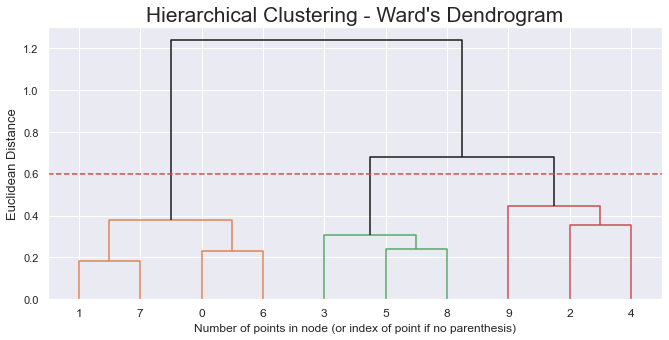

In [82]:
# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py

# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
y_threshold = 0.6
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'{distance.title()} Distance', fontsize=13)
plt.show()

In [83]:
# 5 cluster solution
# linkage = 'ward'
# distance = 'euclidean'
hc3lust = AgglomerativeClustering(linkage=linkage, affinity=distance, n_clusters=3)
hc3_results = hc3lust.fit_predict(centroids)

In [84]:
hc_results=np.zeros_like(labels)
for idx,clust in enumerate(labels):
    hc_results[idx]=hc3_results[clust]
hc_results

array([1, 0, 2, ..., 1, 2, 1])

In [85]:
filled_df['premium_segmentation']=pd.Series(hc_results,name='premium_segmentation',index=filled_df.index)

In [86]:
premium_centroids=filled_df.groupby('premium_segmentation')['CustMonVal', 'PremMotor', 'PremHousehold',
       'PremHealth', 'PremLife', 'PremWork'].mean()
premium_centroids

CustMonVal   PremMotor  PremHousehold  PremHealth  \
premium_segmentation                                                      
0                     353.034419   98.281842     594.501308  156.471597   
1                     210.502614  418.817985      82.547237  120.117991   
2                     179.174067  219.383157     219.961963  229.977639   

                        PremLife    PremWork  
premium_segmentation                          
0                     113.330699  102.929825  
1                      16.726076   16.613584  
2                      46.965840   48.393296

In [87]:
filled_df['premium_segmentation'].value_counts()

1    4850
2    4025
0    1376
Name: premium_segmentation, dtype: int64

## Segmentation BioDemographic - we'll start here today

In [88]:
segmentation_biodemo=['GeoLivArea','Children','EducDeg','MonthSal','BirthYear']

In [89]:
costumerbiodemo = filled_df[segmentation_biodemo]

In [90]:
costumerbiodemo.corr()

MonthSal  BirthYear
MonthSal   1.000000  -0.927191
BirthYear -0.927191   1.000000

In [91]:
def make_educ(col):
    costumerbiodemo[col][costumerbiodemo[col]==costumerbiodemo['EducDeg'].unique()[0]]='Lower_Educ'
    costumerbiodemo[col][costumerbiodemo[col]==costumerbiodemo['EducDeg'].unique()[1]]='Lower_Educ'
    costumerbiodemo[col][costumerbiodemo[col]==costumerbiodemo['EducDeg'].unique()[2]]='Higher_Educ'
    costumerbiodemo[col][costumerbiodemo[col]==costumerbiodemo['EducDeg'].unique()[3]]='Higher_Educ'

In [92]:

print(costumerbiodemo['EducDeg'].unique())
costumerbiodemo['Children']=costumerbiodemo['Children'].apply(lambda x: 'Have' if x==1.0 else 'Dont Have')
costumerbiodemo['GeoLivArea']=costumerbiodemo['GeoLivArea'].astype(str)

#costumerbiodemo['EducDeg_grouped'] = costumerbiodemo['EducDeg'].apply(lambda x: make_educ('EducDeg'))
costumerbiodemo['EducDeg_grouped']=costumerbiodemo['EducDeg']
make_educ('EducDeg_grouped')
#costumerbiodemo['EducDeg'].astype(str)

#df['EducDeg'].unique()[0]


#costumerbiodemo['EducDeg_grouped']=costumerbiodemo['EducDeg_grouped'].apply(lambda x: 'Lower_Educ' if(x['EducDeg']==df['EducDeg'].unique()[0] or x['EducDeg']==df['EducDeg'].unique()[1]) else 'High_Educ')

[b'2 - High School' b'1 - Basic' b'3 - BSc/MSc' b'4 - PhD']


In [93]:
costumerbiodemo.drop('EducDeg',axis=1,inplace=True)

In [94]:
cat = costumerbiodemo[['GeoLivArea','Children','EducDeg_grouped']]
num = costumerbiodemo.drop(['GeoLivArea','Children','EducDeg_grouped'], axis=1)


In [95]:
# Scale the data
scaler_biodemo = MinMaxScaler()

num_scaled = scaler_biodemo.fit_transform(num)
num_scaled = pd.DataFrame(num_scaled, columns = num.columns, index = num.index)

In [96]:
costumerbiodemo=pd.concat([num_scaled,cat],axis=1)

In [97]:
catColumnsPos = [costumerbiodemo.columns.get_loc(col) for col in list(costumerbiodemo.select_dtypes('object').columns)]
print('Categorical columns           : {}'.format(list(costumerbiodemo.select_dtypes('object').columns)))
print('Categorical columns position  : {}'.format(catColumnsPos))

Categorical columns           : ['GeoLivArea', 'Children', 'EducDeg_grouped']
Categorical columns position  : [2, 3, 4]


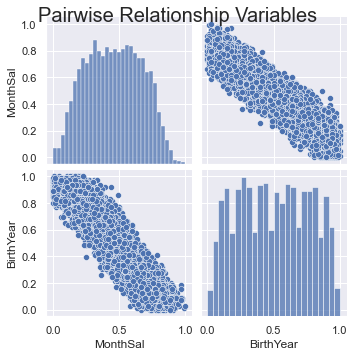

In [98]:
# # Pairwise Relationship of Numerical Variables
sns.set()

# # Setting pairplot
sns.pairplot(costumerbiodemo,diag_kind="hist")

# # Layout
plt.subplots_adjust(top=0.95)
plt.suptitle("Pairwise Relationship Variables", fontsize=20)

plt.show()

In [99]:
dfMatrix = costumerbiodemo.to_numpy()

2818.4907686323045
Cluster initiation: 1
1889.2733761773088
Cluster initiation: 2
1452.8220909338443
Cluster initiation: 3
1269.0448925933802
Cluster initiation: 4
1112.2069222057733
Cluster initiation: 5
1035.4901401260922
Cluster initiation: 6
937.702563780062
Cluster initiation: 7
846.6404790361363
Cluster initiation: 8
832.4592314237539
Cluster initiation: 9


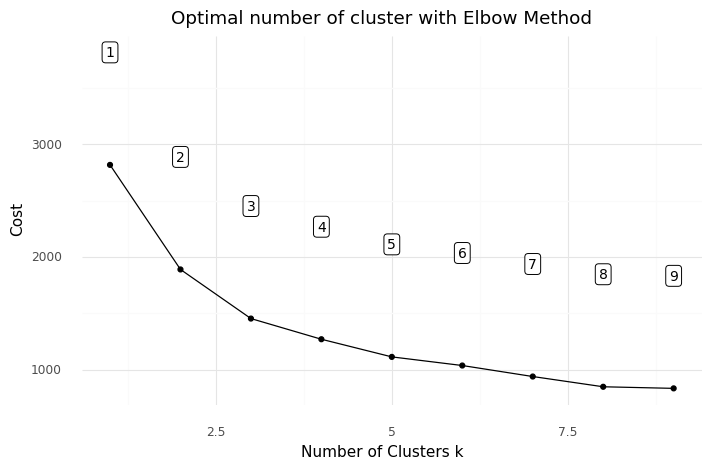

<ggplot: (101369734440)>

In [100]:
# Choose optimal K using Elbow method
cost = []
for cluster in range(1, 10):
    try:
        kprototype = KPrototypes(n_jobs = -1, n_clusters = cluster, init = 'Huang', random_state = 0)
        kprototype.fit_predict(dfMatrix, categorical = catColumnsPos)
        cost.append(kprototype.cost_)
        print(kprototype.cost_)
        print('Cluster initiation: {}'.format(cluster))
    except:
        break
# Converting the results into a dataframe and plotting them
df_cost = pd.DataFrame({'Cluster':range(1, 10), 'Cost':cost})
# Data viz
plotnine.options.figure_size = (8, 4.8)
(
    ggplot(data = df_cost)+
    geom_line(aes(x = 'Cluster',
                  y = 'Cost'))+
    geom_point(aes(x = 'Cluster',
                   y = 'Cost'))+
    geom_label(aes(x = 'Cluster',
                   y = 'Cost',
                   label = 'Cluster'),
               size = 10,
               nudge_y = 1000) +
    labs(title = 'Optimal number of cluster with Elbow Method')+
    xlab('Number of Clusters k')+
    ylab('Cost')+
    theme_minimal()
)

### Clustering K=3

In [101]:
# Fit the cluster
kprototype = KPrototypes(n_jobs = -1, n_clusters = 3, init = 'Huang', random_state = 0)
kprototype.fit_predict(dfMatrix, categorical = catColumnsPos)

array([1, 1, 1, ..., 2, 1, 2], dtype=uint16)

In [102]:
# Add the cluster to the dataframe
filled_df['BioDemo_Segmentation'] = kprototype.labels_


In [103]:
biodemo_scaled_centrois=pd.DataFrame(kprototype.cluster_centroids_,columns=costumerbiodemo.columns)
biodemo_scaled_centrois

MonthSal            BirthYear GeoLivArea   Children  \
0   0.7000157940289385  0.19092463623927655        4.0  Dont Have   
1   0.2761152626973837   0.7424259386476081        4.0       Have   
2  0.45366744755537197   0.5134410164511378        1.0       Have   

  EducDeg_grouped  
0     Higher_Educ  
1      Lower_Educ  
2     Higher_Educ

In [104]:
biodemo_centrois=biodemo_scaled_centrois.copy()

In [105]:
biodemo_centrois['MonthSal']=filled_df.groupby("BioDemo_Segmentation")['MonthSal', 'BirthYear'].mean()['MonthSal']
biodemo_centrois['BirthYear']=filled_df.groupby("BioDemo_Segmentation")['MonthSal', 'BirthYear'].mean()['BirthYear']

In [106]:
biodemo_centrois

MonthSal    BirthYear GeoLivArea   Children EducDeg_grouped
0  3614.674042  1947.601026        4.0  Dont Have     Higher_Educ
1  1627.428352  1984.000112        4.0       Have      Lower_Educ
2  2459.792994  1968.887107        1.0       Have     Higher_Educ

In [107]:
costumerbiodemo['BioDemo_Segmentation'] = kprototype.labels_
costumerbiodemo.groupby(["BioDemo_Segmentation","EducDeg_grouped"]).size().unstack(fill_value=0)

EducDeg_grouped       Higher_Educ  Lower_Educ
BioDemo_Segmentation                         
0                            1716        1208
1                             808        2765
2                            2963         791

In [108]:
costumerbiodemo.groupby(["BioDemo_Segmentation","Children"]).size().unstack(fill_value=0)

Children              Dont Have  Have
BioDemo_Segmentation                 
0                          2367   557
1                           450  3123
2                           184  3570

In [109]:
costumerbiodemo.groupby(["BioDemo_Segmentation","GeoLivArea"]).size().unstack(fill_value=0)

GeoLivArea             1.0  2.0  3.0   4.0
BioDemo_Segmentation                      
0                      648  281  514  1481
1                      600  313  659  2001
2                     1790  442  877   645

In [110]:
filled_df.groupby(["GeoLivArea"])["MonthSal"].mean()

GeoLivArea
1.0    2474.641047
2.0    2563.090154
3.0    2482.622244
4.0    2509.201551
Name: MonthSal, dtype: float64

In [111]:
df_features=costumerbiodemo.drop(['GeoLivArea','Children','EducDeg_grouped'],axis=1)

In [112]:
def outside_limit(df, label_col, label, sensitivity):
    feature_list = num_scaled.columns
    plot_list = []
    mean_overall_list = []
    mean_cluster_list = []
    dif_list=[]
    for i,varname in enumerate(feature_list):
    
   
        mean_overall = df[varname].mean()
        std_overall=  df[varname].std()
        n_overall= df[varname].shape[0]
        lower_limit = mean_overall - (mean_overall*sensitivity)
        upper_limit = mean_overall + (mean_overall*sensitivity)


        cluster_filter = df[label_col]==label
        pd_cluster = df[cluster_filter]
        mean_cluster = pd_cluster[varname].mean()


        #if mean_cluster <= lower_limit or mean_cluster >= upper_limit:
        plot_list.append(varname)
        mean_overall_std = mean_overall/mean_overall
        mean_cluster_std = mean_cluster/mean_overall-1
        mean_overall_list.append(mean_overall_std)
        mean_cluster_list.append(mean_cluster_std)
   
    mean_df = pd.DataFrame({'feature_list':plot_list,
                         'mean_overall_list':mean_overall_list,
                         'mean_cluster_list':mean_cluster_list})
    mean_df = mean_df.sort_values(by=['mean_cluster_list'], ascending=False)

    return mean_df





def plot_barchart_all_unique_features(df, label_col, label, ax, sensitivity):
  
    mean_df = outside_limit(df, label_col, label, sensitivity)
    mean_df_to_plot = mean_df.drop(['mean_overall_list'], axis=1)
    
    
  
    if len(mean_df.index) != 0:
        sns.barplot(y='feature_list', x='mean_cluster_list', data=mean_df_to_plot, palette=sns.cubehelix_palette(20, start=.5, rot=-.75, reverse=True), \
                alpha=0.75, dodge=True, ax=ax)

        for i,p in enumerate(ax.patches):
            ax.annotate("{:.02f}".format((p.get_width())), 
                  (1, p.get_y() + p.get_height() / 2.), xycoords=('axes fraction', 'data'),
                  ha='right', va='top', fontsize=10, color='black', rotation=0, 
                  xytext=(0, 0),
                  textcoords='offset pixels')
  
            ax.set_title('Unique Characteristics of Cluster ' + str(label))
            ax.set_xlabel('Standardized Mean')
            #x.axvline(x=1, color='k')

def plot_features_all_cluster(df, label_col, n_clusters, sensitivity):
    n_plot = n_clusters
    fig, ax = plt.subplots(n_plot, 1, figsize=(12, n_plot*6), sharex='col')
    ax= ax.ravel()
  
    label = np.arange(n_clusters)
    for i in label:
        plot_barchart_all_unique_features(df, label_col, label=i, ax=ax[i], sensitivity=sensitivity)
        ax[i].xaxis.set_tick_params(labelbottom=True)
    plt.tight_layout()

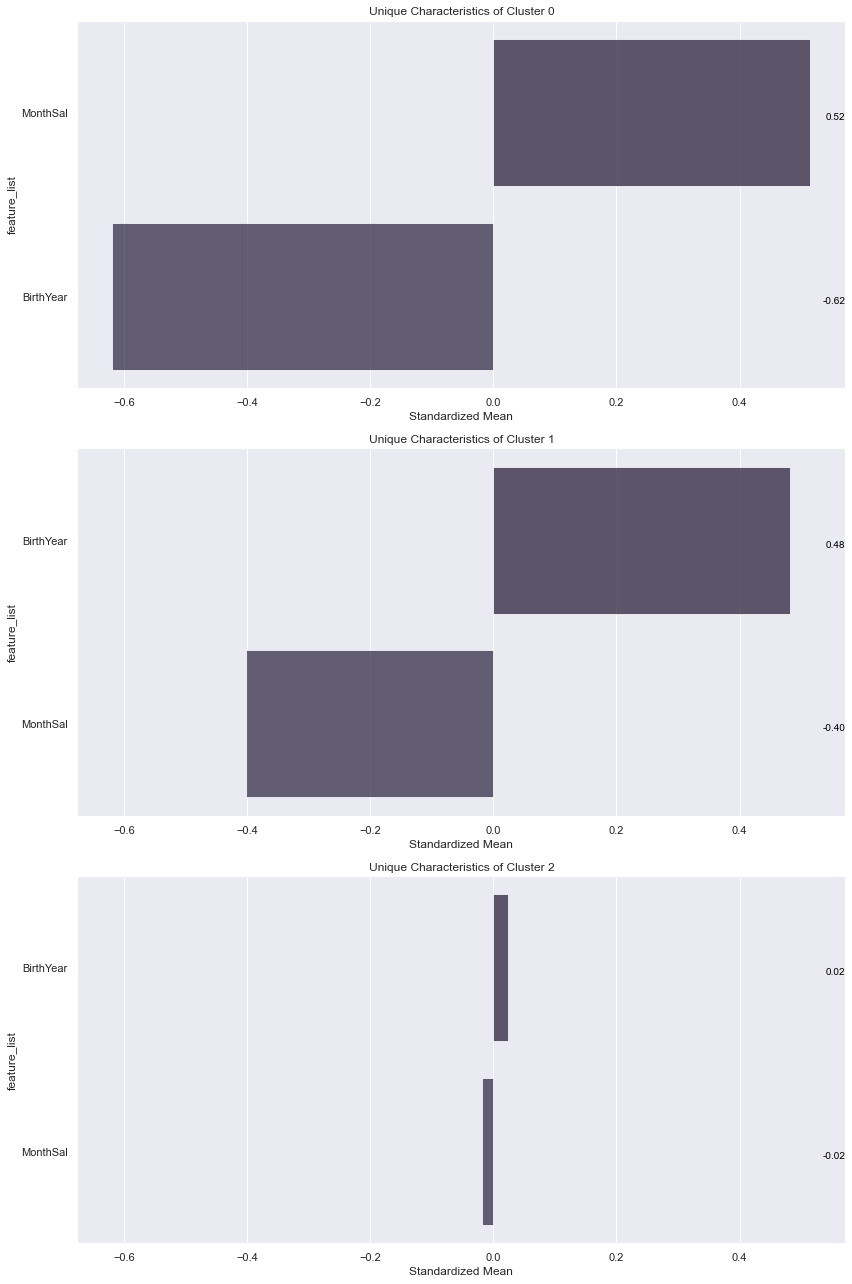

In [113]:
plot_features_all_cluster(df=df_features, label_col='BioDemo_Segmentation', n_clusters=3, sensitivity=0.001)

### CROSS-RESULTS

In [114]:
filled_df.groupby(['BioDemo_Segmentation','premium_segmentation']).mean()

FirstPolYear    BirthYear  \
BioDemo_Segmentation premium_segmentation                              
0                    0                      1986.776824  1947.069957   
                     1                      1985.953578  1949.562994   
                     2                      1986.270780  1946.397913   
1                    0                      1985.895833  1992.724206   
                     1                      1985.850466  1975.735568   
                     2                      1986.146814  1984.055265   
2                    0                      1987.022222  1972.970370   
                     1                      1985.848821  1967.737841   
                     2                      1985.890276  1971.724530   

                                              MonthSal  CustMonVal  \
BioDemo_Segmentation premium_segmentation                            
0                    0                     3643.852361  391.219742   
                     1                     3517.390113  202.188738   
                     2                     3673.923266  175.109699   
1                    0                     1197.386111  333.567778   
                     1                     2043.021788  219.854488   
                     2                     1618.800067  180.126821   
2                    0                     2281.088889  432.480296   
                     1                     2516.384046  210.055092   
                     2                     2316.739890  184.920254   

                                           ClaimsRate   PremMotor  \
BioDemo_Segmentation premium_segmentation                           
0                    0                       0.602060  128.498047   
                     1                       0.657787  390.527562   
                     2                       0.740933  218.670634   
1                    0                       0.680437   84.654544   
                     1                       0.632644  404.263884   
                     2                       0.738182  205.361645   
2                    0                       0.571630  147.881407   
                     1                       0.636868  435.647584   
                     2                       0.726343  243.766335   

                                           PremHousehold  PremHealth  \
BioDemo_Segmentation premium_segmentation                              
0                    0                        564.688841  177.354378   
                     1                        100.806026  138.856791   
                     2                        213.420196  237.356276   
1                    0                        601.898958  151.134313   
                     1                         96.635987  127.594592   
                     2                        234.589202  232.206954   
2                    0                        590.719630  160.281185   
                     1                         69.827211  109.826732   
                     2                        207.638564  213.023265   

                                             PremLife    PremWork  
BioDemo_Segmentation premium_segmentation                          
0                    0                      95.328069   74.562605  
                     1                      20.048695   19.637804  
                     2                      44.853611   45.080054  
1                    0                     121.085607  112.961560  
                     1                      19.168223   19.053018  
                     2                      50.418747   53.706266  
2                    0                      86.498593   76.985926  
                     1                      14.459501   14.464847  
                     2                      45.079139   45.603943

In [115]:
filled_df.groupby(['BioDemo_Segmentation','premium_segmentation']).count()

FirstPolYear  BirthYear  MonthSal  \
BioDemo_Segmentation premium_segmentation                                      
0                    0                              233        233       233   
                     1                             1062       1062      1062   
                     2                             1629       1629      1629   
1                    0                             1008       1008      1008   
                     1                             1074       1074      1074   
                     2                             1491       1491      1491   
2                    0                              135        135       135   
                     1                             2714       2714      2714   
                     2                              905        905       905   

                                           CustMonVal  ClaimsRate  PremMotor  \
BioDemo_Segmentation premium_segmentation                                      
0                    0                            233         233        233   
                     1                           1062        1062       1062   
                     2                           1629        1629       1629   
1                    0                           1008        1008       1008   
                     1                           1074        1074       1074   
                     2                           1491        1491       1491   
2                    0                            135         135        135   
                     1                           2714        2714       2714   
                     2                            905         905        905   

                                           PremHousehold  PremHealth  \
BioDemo_Segmentation premium_segmentation                              
0                    0                               233         233   
                     1                              1062        1062   
                     2                              1629        1629   
1                    0                              1008        1008   
                     1                              1074        1074   
                     2                              1491        1491   
2                    0                               135         135   
                     1                              2714        2714   
                     2                               905         905   

                                           PremLife  PremWork  EducDeg  \
BioDemo_Segmentation premium_segmentation                                
0                    0                          233       233      233   
                     1                         1062      1062     1062   
                     2                         1629      1629     1629   
1                    0                         1008      1008     1008   
                     1                         1074      1074     1074   
                     2                         1491      1491     1491   
2                    0                          135       135      135   
                     1                         2714      2714     2714   
                     2                          905       905      905   

                                           GeoLivArea  Children  
BioDemo_Segmentation premium_segmentation                        
0                    0                            233       233  
                     1                           1062      1062  
                     2                           1629      1629  
1                    0                           1008      1008  
                     1                           1074      1074  
                     2                           1491      1491  
2                    0                            135       135  
                     1                           2714      2714  
             

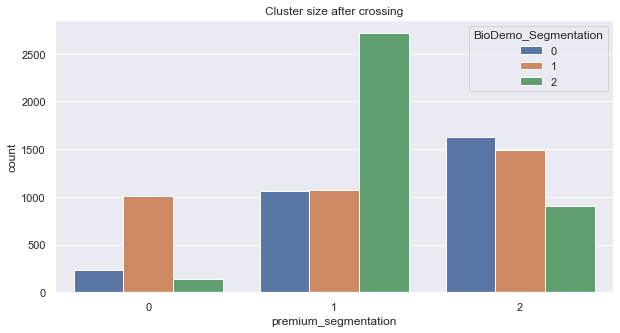

In [116]:
plt.figure(figsize = (10, 5))
sns.countplot(data=filled_df, x = 'premium_segmentation', hue="BioDemo_Segmentation")
plt.title("Cluster size after crossing")
plt.show()

In [117]:
pd.DataFrame(kprototype.cluster_centroids_)

0                    1    2          3            4
0   0.7000157940289385  0.19092463623927655  4.0  Dont Have  Higher_Educ
1   0.2761152626973837   0.7424259386476081  4.0       Have   Lower_Educ
2  0.45366744755537197   0.5134410164511378  1.0       Have  Higher_Educ

### Merging the prespectives 

In [118]:
# Count label frequencies (contigency table)
filled_df.groupby(['premium_segmentation', 'BioDemo_Segmentation'])\
    .size()\
    .to_frame()\
    .reset_index()\
    .pivot('BioDemo_Segmentation', 'premium_segmentation', 0)

premium_segmentation     0     1     2
BioDemo_Segmentation                  
0                      233  1062  1629
1                     1008  1074  1491
2                      135  2714   905

In [119]:
features=['PremMotor', 'PremHousehold',
       'PremHealth', 'PremLife', 'PremWork','BirthYear', 'MonthSal','CustMonVal']

In [120]:
# Clusters with low frequency to be merged:
to_merge = [(0,0), (2,0)]

df_centroids = filled_df.groupby(['BioDemo_Segmentation', 'premium_segmentation'])\
    [features].mean()

# Computing the euclidean distance matrix between the centroids
euclidean = pairwise_distances(df_centroids)
df_dists = pd.DataFrame(
    euclidean, columns=df_centroids.index, index=df_centroids.index
)

# Merging each low frequency clustering (source) to the closest cluster (target)
source_target = {}
for clus in to_merge:
    if clus not in source_target.values():
        source_target[clus] = df_dists.loc[clus].sort_values().index[1]

source_target

{(0, 0): (0, 2), (2, 0): (2, 2)}

In [121]:
df_ = filled_df.copy()

# Changing the behavior_labels and product_labels based on source_target
for source, target in source_target.items():
    mask = (df_['BioDemo_Segmentation']==source[0]) & (df_['premium_segmentation']==source[1])
    df_.loc[mask, 'BioDemo_Segmentation'] = target[0]
    df_.loc[mask, 'premium_segmentation'] = target[1]

# New contigency table
df_.groupby(['premium_segmentation', 'BioDemo_Segmentation'])\
    .size()\
    .to_frame()\
    .reset_index()\
    .pivot('BioDemo_Segmentation', 'premium_segmentation', 0)

premium_segmentation       0       1       2
BioDemo_Segmentation                        
0                        NaN  1062.0  1862.0
1                     1008.0  1074.0  1491.0
2                        NaN  2714.0  1040.0

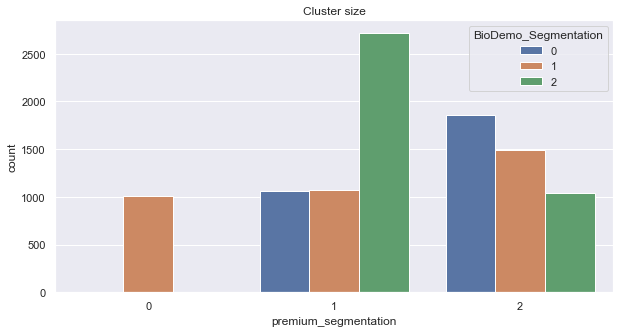

In [122]:
plt.figure(figsize = (10, 5))
sns.countplot(data=df_, x = 'premium_segmentation', hue="BioDemo_Segmentation")
plt.title("Cluster size")
plt.show()

In [123]:
df_.groupby(['premium_segmentation','BioDemo_Segmentation']).mean()

FirstPolYear    BirthYear  \
premium_segmentation BioDemo_Segmentation                              
0                    1                      1985.895833  1992.724206   
1                    0                      1985.953578  1949.562994   
                     1                      1985.850466  1975.735568   
                     2                      1985.848821  1967.737841   
2                    0                      1986.334103  1946.482009   
                     1                      1986.146814  1984.055265   
                     2                      1986.037212  1971.886250   

                                              MonthSal  CustMonVal  \
premium_segmentation BioDemo_Segmentation                            
0                    1                     1197.386111  333.567778   
1                    0                     3517.390113  202.188738   
                     1                     2043.021788  219.854488   
                     2                     2516.384046  210.055092   
2                    0                     3670.160365  202.152470   
                     1                     1618.800067  180.126821   
                     2                     2312.112115  217.055452   

                                           ClaimsRate   PremMotor  \
premium_segmentation BioDemo_Segmentation                           
0                    1                       0.680437   84.654544   
1                    0                       0.657787  390.527562   
                     1                       0.632644  404.263884   
                     2                       0.636868  435.647584   
2                    0                       0.723555  207.386954   
                     1                       0.738182  205.361645   
                     2                       0.706260  231.319734   

                                           PremHousehold  PremHealth  \
premium_segmentation BioDemo_Segmentation                              
0                    1                        601.898958  151.134313   
1                    0                        100.806026  138.856791   
                     1                         96.635987  127.594592   
                     2                         69.827211  109.826732   
2                    0                        257.375940  229.847983   
                     1                        234.589202  232.206954   
                     2                        257.365433  206.176938   

                                             PremLife    PremWork  
premium_segmentation BioDemo_Segmentation                          
0                    1                     121.085607  112.961560  
1                    0                      20.048695   19.637804  
                     1                      19.168223   19.053018  
                     2                      14.459501   14.464847  
2                    0                      51.169695   48.769331  
                     1                      50.418747   53.706266  
                     2                      50.455703   49.677565

In [124]:
df_.groupby(['premium_segmentation','BioDemo_Segmentation'])['EducDeg','GeoLivArea','Children'].agg(lambda x:x.value_counts().index[0])

EducDeg  GeoLivArea  \
premium_segmentation BioDemo_Segmentation                                   
0                    1                           b'1 - Basic'         4.0   
1                    0                         b'3 - BSc/MSc'         4.0   
                     1                     b'2 - High School'         4.0   
                     2                         b'3 - BSc/MSc'         1.0   
2                    0                         b'3 - BSc/MSc'         4.0   
                     1                     b'2 - High School'         4.0   
                     2                         b'3 - BSc/MSc'         1.0   

                                           Children  
premium_segmentation BioDemo_Segmentation            
0                    1                          1.0  
1                    0                          0.0  
                     1                          1.0  
                     2                          1.0  
2                    0                          0.0  
                     1                          1.0  
                     2                          1.0

In [125]:
df_.groupby(['premium_segmentation','BioDemo_Segmentation']).count()

FirstPolYear  BirthYear  MonthSal  \
premium_segmentation BioDemo_Segmentation                                      
0                    1                             1008       1008      1008   
1                    0                             1062       1062      1062   
                     1                             1074       1074      1074   
                     2                             2714       2714      2714   
2                    0                             1862       1862      1862   
                     1                             1491       1491      1491   
                     2                             1040       1040      1040   

                                           CustMonVal  ClaimsRate  PremMotor  \
premium_segmentation BioDemo_Segmentation                                      
0                    1                           1008        1008       1008   
1                    0                           1062        1062       1062   
                     1                           1074        1074       1074   
                     2                           2714        2714       2714   
2                    0                           1862        1862       1862   
                     1                           1491        1491       1491   
                     2                           1040        1040       1040   

                                           PremHousehold  PremHealth  \
premium_segmentation BioDemo_Segmentation                              
0                    1                              1008        1008   
1                    0                              1062        1062   
                     1                              1074        1074   
                     2                              2714        2714   
2                    0                              1862        1862   
                     1                              1491        1491   
                     2                              1040        1040   

                                           PremLife  PremWork  EducDeg  \
premium_segmentation BioDemo_Segmentation                                
0                    1                         1008      1008     1008   
1                    0                         1062      1062     1062   
                     1                         1074      1074     1074   
                     2                         2714      2714     2714   
2                    0                         1862      1862     1862   
                     1                         1491      1491     1491   
                     2                         1040      1040     1040   

                                           GeoLivArea  Children  
premium_segmentation BioDemo_Segmentation                        
0                    1                           1008      1008  
1                    0                           1062      1062  
                     1                           1074      1074  
                     2                           2714      2714  
2                    0                           1862      1862  
                     1                           1491      1491  
                     2                           1040      1040

In [126]:
df_['merged_labels'] = df_['premium_segmentation'].astype(str)+df_['BioDemo_Segmentation'].astype(str)
df_['merged_labels'].unique()
df_['merged_labels'][df_['merged_labels']=='01']=1
df_['merged_labels'][df_['merged_labels']=='10']=2
df_['merged_labels'][df_['merged_labels']=='11']=3
df_['merged_labels'][df_['merged_labels']=='12']=4
df_['merged_labels'][df_['merged_labels']=='20']=5
df_['merged_labels'][df_['merged_labels']=='21']=6
df_['merged_labels'][df_['merged_labels']=='22']=7
df_['merged_labels']

0        3
1        1
2        6
3        6
4        4
        ..
10290    1
10291    2
10293    4
10294    6
10295    4
Name: merged_labels, Length: 10251, dtype: object

In [127]:
def cluster_profiles(df, label_columns, figsize, compar_titles=None):
    """
    Pass df with labels columns of one or multiple clustering labels. 
    Then specify this label columns to perform the cluster profile according to them.
    """
    if compar_titles == None:
        compar_titles = [""]*len(label_columns)
        
    sns.set()
    fig, axes = plt.subplots(nrows=len(label_columns), ncols=2, figsize=figsize, squeeze=False)
    for ax, label, titl in zip(axes, label_columns, compar_titles):
        # Filtering df
        drop_cols = [i for i in label_columns if i!=label]
        dfax = df.drop(drop_cols, axis=1)
        
        # Getting the cluster centroids and counts
        centroids = dfax.groupby(by=label, as_index=False).mean()
        counts = dfax.groupby(by=label, as_index=False).count().iloc[:,[0,1]]
        counts.columns = [label, "counts"]
        
        # Setting Data
        pd.plotting.parallel_coordinates(centroids, label, color=sns.color_palette(), ax=ax[0])
        sns.barplot(x=label, y="counts", data=counts, ax=ax[1])

        #Setting Layout
        handles, _ = ax[0].get_legend_handles_labels()
        cluster_labels = ["Cluster {}".format(i) for i in range(len(handles))]
        ax[0].annotate(text=titl, xy=(0.95,1.1), xycoords='axes fraction', fontsize=13, fontweight = 'heavy') 
        ax[0].legend(handles, cluster_labels) # Adaptable to number of clusters
        ax[0].axhline(color="black", linestyle="--")
        ax[0].set_title("Cluster Means - {} Clusters".format(len(handles)), fontsize=13)
        ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=-20)
        ax[1].set_xticklabels(cluster_labels)
        ax[1].set_xlabel("")
        ax[1].set_ylabel("Absolute Frequency")
        ax[1].set_title("Cluster Sizes - {} Clusters".format(len(handles)), fontsize=13)
    
    plt.subplots_adjust(hspace=0.4, top=0.90)
    plt.suptitle("Cluster Simple Profilling", fontsize=23)
    plt.show()

In [128]:
df_.columns

Index(['FirstPolYear', 'BirthYear', 'MonthSal', 'CustMonVal', 'ClaimsRate',
       'PremMotor', 'PremHousehold', 'PremHealth', 'PremLife', 'PremWork',
       'EducDeg', 'GeoLivArea', 'Children', 'premium_segmentation',
       'BioDemo_Segmentation', 'merged_labels'],
      dtype='object')

In [129]:
num_df = df_[['FirstPolYear', 'BirthYear', 'MonthSal', 'CustMonVal', 'ClaimsRate',
       'PremMotor', 'PremHousehold', 'PremHealth', 'PremLife', 'PremWork']]
non_num_df_ = df_[['GeoLivArea','Children','EducDeg', 'premium_segmentation',
       'BioDemo_Segmentation', 'merged_labels']]

# Scale the data
scaler_df_ = MinMaxScaler()

num_scaled = scaler_df_.fit_transform(num_df)
num_scaled = pd.DataFrame(num_scaled, columns = num_df.columns, index = num_df.index)
scaled_df_=pd.concat([num_scaled,non_num_df_],axis=1)

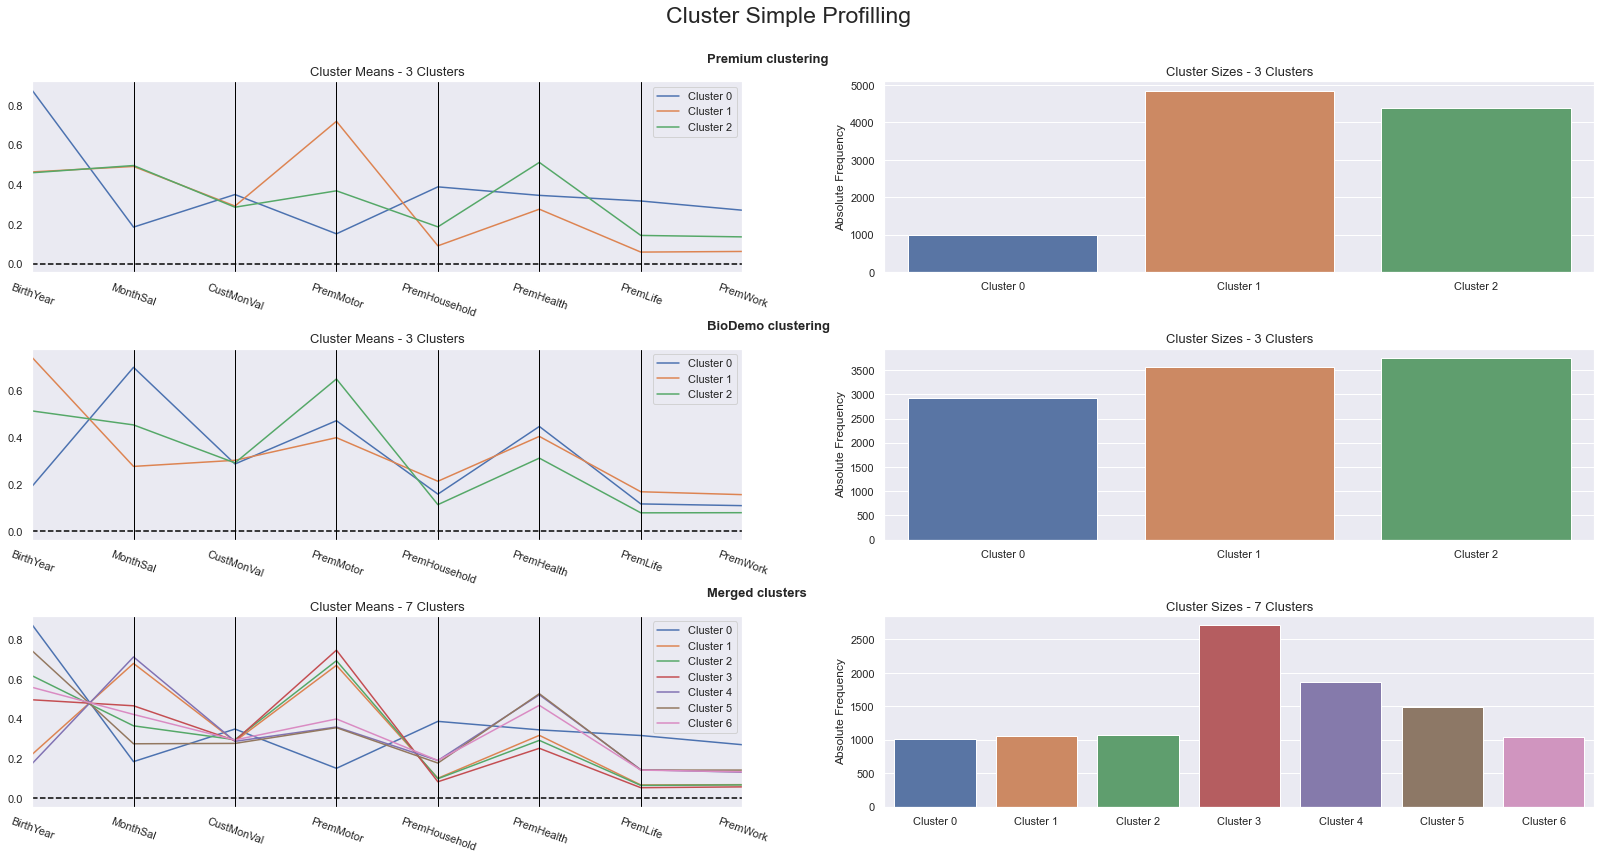

In [130]:
# Profilling each cluster (product, behavior, merged)
cluster_profiles(
    df = scaled_df_[['BirthYear', 'MonthSal', 'CustMonVal',
       'PremMotor', 'PremHousehold', 'PremHealth', 'PremLife', 'PremWork','premium_segmentation', 'BioDemo_Segmentation', 'merged_labels']], 
    label_columns = ['premium_segmentation', 'BioDemo_Segmentation', 'merged_labels'], 
    figsize = (28, 13), 
    compar_titles = ["Premium clustering", "BioDemo clustering", "Merged clusters"]
)

In [131]:
final_centroids=pd.concat([df_.groupby(['premium_segmentation','BioDemo_Segmentation']).mean().round(2)
            ,df_.groupby(['premium_segmentation','BioDemo_Segmentation'])['EducDeg','GeoLivArea','Children'].agg(lambda x:x.value_counts().index[0])]
          ,axis=1)
final_centroids

FirstPolYear  BirthYear  MonthSal  \
premium_segmentation BioDemo_Segmentation                                      
0                    1                          1985.90    1992.72   1197.39   
1                    0                          1985.95    1949.56   3517.39   
                     1                          1985.85    1975.74   2043.02   
                     2                          1985.85    1967.74   2516.38   
2                    0                          1986.33    1946.48   3670.16   
                     1                          1986.15    1984.06   1618.80   
                     2                          1986.04    1971.89   2312.11   

                                           CustMonVal  ClaimsRate  PremMotor  \
premium_segmentation BioDemo_Segmentation                                      
0                    1                         333.57        0.68      84.65   
1                    0                         202.19        0.66     390.53   
                     1                         219.85        0.63     404.26   
                     2                         210.06        0.64     435.65   
2                    0                         202.15        0.72     207.39   
                     1                         180.13        0.74     205.36   
                     2                         217.06        0.71     231.32   

                                           PremHousehold  PremHealth  \
premium_segmentation BioDemo_Segmentation                              
0                    1                            601.90      151.13   
1                    0                            100.81      138.86   
                     1                             96.64      127.59   
                     2                             69.83      109.83   
2                    0                            257.38      229.85   
                     1                            234.59      232.21   
                     2                            257.37      206.18   

                                           PremLife  PremWork  \
premium_segmentation BioDemo_Segmentation                       
0                    1                       121.09    112.96   
1                    0                        20.05     19.64   
                     1                        19.17     19.05   
                     2                        14.46     14.46   
2                    0                        51.17     48.77   
                     1                        50.42     53.71   
                     2                        50.46     49.68   

                                                      EducDeg  GeoLivArea  \
premium_segmentation BioDemo_Segmentation                                   
0                    1                           b'1 - Basic'         4.0   
1                    0                         b'3 - BSc/MSc'         4.0   
                     1                     b'2 - High School'         4.0   
                     2                         b'3 - BSc/MSc'         1.0   
2                    0                         b'3 - BSc/MSc'         4.0   
                     1                     b'2 - High School'         4.0   
                     2                         b'3 - BSc/MSc'         1.0   

                                           Children  
premium_segmentation BioDemo_Segmentation            
0                    1                          1.0  
1                    0                          0.0  
                     1                          1.0  
                     2                          1.0  
2                    0                          0.0  
                     1                          1.0  
                     2                          1.0

Final clusters size

In [132]:
pd.DataFrame(pd.Series(df_.groupby(['merged_labels']).size(),name='Cluster Size'))

Cluster Size
merged_labels              
1                      1008
2                      1062
3                      1074
4                      2714
5                      1862
6                      1491
7                      1040

In [133]:
final_centroids=pd.concat([df_.groupby(['merged_labels']).mean().round()
            ,df_.groupby(['merged_labels'])['EducDeg','GeoLivArea','Children'].agg(lambda x:x.value_counts().index[0])]
          ,axis=1)[['FirstPolYear','BirthYear','MonthSal','CustMonVal','ClaimsRate','PremMotor','PremHousehold','PremHealth','PremLife','PremWork','EducDeg','GeoLivArea','Children']]
final_centroids

FirstPolYear  BirthYear  MonthSal  CustMonVal  ClaimsRate  \
merged_labels                                                              
1                    1986.0     1993.0    1197.0       334.0         1.0   
2                    1986.0     1950.0    3517.0       202.0         1.0   
3                    1986.0     1976.0    2043.0       220.0         1.0   
4                    1986.0     1968.0    2516.0       210.0         1.0   
5                    1986.0     1946.0    3670.0       202.0         1.0   
6                    1986.0     1984.0    1619.0       180.0         1.0   
7                    1986.0     1972.0    2312.0       217.0         1.0   

               PremMotor  PremHousehold  PremHealth  PremLife  PremWork  \
merged_labels                                                             
1                   85.0          602.0       151.0     121.0     113.0   
2                  391.0          101.0       139.0      20.0      20.0   
3                  404.0           97.0       128.0      19.0      19.0   
4                  436.0           70.0       110.0      14.0      14.0   
5                  207.0          257.0       230.0      51.0      49.0   
6                  205.0          235.0       232.0      50.0      54.0   
7                  231.0          257.0       206.0      50.0      50.0   

                          EducDeg  GeoLivArea  Children  
merged_labels                                            
1                    b'1 - Basic'         4.0       1.0  
2                  b'3 - BSc/MSc'         4.0       0.0  
3              b'2 - High School'         4.0       1.0  
4                  b'3 - BSc/MSc'         1.0       1.0  
5                  b'3 - BSc/MSc'         4.0       0.0  
6              b'2 - High School'         4.0       1.0  
7                  b'3 - BSc/MSc'         1.0       1.0

In [134]:
np.abs(final_centroids['BirthYear']-2016)

merged_labels
1    23.0
2    66.0
3    40.0
4    48.0
5    70.0
6    32.0
7    44.0
Name: BirthYear, dtype: float64

## Clusters Analysis

Cluster 1: <br> 
-Youngest people <br>
-Lower salary <br>
-Most valuable clients <br>
-Spend more in Premium Household, spend some in the Health, Life and Work and spend less in Motor <br>
-The most comun education degree is Basic <br>
-The majority has childrens<br>

Clusters 2,3,4: <br>
-Spend more in motor <br>
-Spend some in Household and Health <br>
-Spend few in Life and Work <br>

Cluster 2(in detail): <br>
-Most comun Education Degree is HigherEduc <br>
-The have children <br>

Cluster 3 (in detail) : <br>
-Older people <br>
-Higher salary <br>
-Have no children <br>
-High Education <br>

Cluster 4: <br>
-Younger people (comparing with 2,3,4) <br>
-Have children <br>
-Most comun degree is highschool<br>

Cluster 5,6,7: <br>
-They spend most in Motor, Household and Health <br>
-Spend less in Life and Work <br>

Cluster 5: <br>
-Most comun Education Degree is HigherEduc <br>
-The have children <br>

Cluster 6 (in detail) : <br>
-Older people <br>
-Higher salary <br>
-Have no children <br>
-High Education <br>

Cluster 7: <br>
-Younger people (comparing with 2,3,4) <br>
-Have children <br>
-Most comun degree is highschool<br>

## Merging Outliers

### For Premium segmentation

In [135]:
scaled_premiums = scaler_premium.transform(df_outliers[premiumns_feat])

In [136]:
premium_centroids

CustMonVal   PremMotor  PremHousehold  PremHealth  \
premium_segmentation                                                      
0                     353.034419   98.281842     594.501308  156.471597   
1                     210.502614  418.817985      82.547237  120.117991   
2                     179.174067  219.383157     219.961963  229.977639   

                        PremLife    PremWork  
premium_segmentation                          
0                     113.330699  102.929825  
1                      16.726076   16.613584  
2                      46.965840   48.393296

In [137]:
pred_premium=KMeans(n_clusters=3).fit(premium_centroids).predict(scaled_premiums)

In [138]:
df_outliers['premium_segmentation']=pred_premium

### For BioDemo segmentation

In [139]:
segmentation_biodemo=['GeoLivArea','Children','EducDeg','MonthSal','BirthYear']
costumerbiodemo = df_outliers[segmentation_biodemo]

costumerbiodemo['Children']=costumerbiodemo['Children'].apply(lambda x: 'Have' if x==1.0 else 'Dont Have')
costumerbiodemo['GeoLivArea']=costumerbiodemo['GeoLivArea'].astype(str)
costumerbiodemo['EducDeg_grouped']=costumerbiodemo['EducDeg']
make_educ('EducDeg_grouped')
costumerbiodemo.drop('EducDeg',axis=1,inplace=True)

cat = costumerbiodemo[['GeoLivArea','Children','EducDeg_grouped']]
num = costumerbiodemo.drop(['GeoLivArea','Children','EducDeg_grouped'], axis=1)

num_scaled = scaler_biodemo.fit_transform(num)
num_scaled = pd.DataFrame(num_scaled, columns = num.columns, index = num.index)
costumerbiodemo=pd.concat([num_scaled,cat],axis=1)

catColumnsPos = [costumerbiodemo.columns.get_loc(col) for col in list(costumerbiodemo.select_dtypes('object').columns)]

dfMatrix = costumerbiodemo.to_numpy()



In [140]:
pred_biodemo_outliers=kprototype.predict(dfMatrix, categorical = catColumnsPos)

In [141]:
df_outliers['BioDemo_Segmentation']=pred_biodemo_outliers

## Final

In [142]:
final_df=pd.concat([df_,df_outliers])

In [143]:
# New contigency table
final_df.groupby(['premium_segmentation', 'BioDemo_Segmentation'])\
    .size()\
    .to_frame()\
    .reset_index()\
    .pivot('BioDemo_Segmentation', 'premium_segmentation', 0)

premium_segmentation     0     1     2
BioDemo_Segmentation                  
0                        1  1062  1862
1                     1051  1074  1491
2                        1  2714  1040

In [144]:
if(final_df.groupby(['premium_segmentation', 'BioDemo_Segmentation'])\
    .size()\
    .to_frame()\
    .reset_index()\
    .pivot('BioDemo_Segmentation', 'premium_segmentation', 0)[0][0]==1):
# Clusters with low frequency to be merged:
    to_merge = [(0,0),(2,0)]

    df_centroids = final_df.groupby(['BioDemo_Segmentation', 'premium_segmentation'])\
        [features].mean()

    # Computing the euclidean distance matrix between the centroids
    euclidean = pairwise_distances(df_centroids)
    df_dists = pd.DataFrame(
        euclidean, columns=df_centroids.index, index=df_centroids.index
    )

    # Merging each low frequency clustering (source) to the closest cluster (target)
    source_target = {}
    for clus in to_merge:
        if clus not in source_target.values():
            source_target[clus] = df_dists.loc[clus].sort_values().index[1]

    source_target



    # Changing the behavior_labels and product_labels based on source_target
    for source, target in source_target.items():
        mask = (final_df['BioDemo_Segmentation']==source[0]) & (final_df['premium_segmentation']==source[1])
        final_df.loc[mask, 'BioDemo_Segmentation'] = target[0]
        final_df.loc[mask, 'premium_segmentation'] = target[1]

    # New contigency table
    print(final_df.groupby(['premium_segmentation', 'BioDemo_Segmentation'])\
        .size()\
        .to_frame()\
        .reset_index()\
        .pivot('BioDemo_Segmentation', 'premium_segmentation', 0))

premium_segmentation       0       1       2
BioDemo_Segmentation                        
0                        NaN  1062.0  1863.0
1                     1051.0  1074.0  1491.0
2                        NaN  2715.0  1040.0


In [145]:
final_df['merged_labels'] = final_df['premium_segmentation'].astype(str)+final_df['BioDemo_Segmentation'].astype(str)
final_df['merged_labels'].unique()

array(['11', '01', '21', '12', '20', '22', '10'], dtype=object)

In [146]:
final_df['merged_labels'][final_df['merged_labels']=='01']=1
final_df['merged_labels'][final_df['merged_labels']=='10']=2
final_df['merged_labels'][final_df['merged_labels']=='11']=3
final_df['merged_labels'][final_df['merged_labels']=='12']=4
final_df['merged_labels'][final_df['merged_labels']=='20']=5
final_df['merged_labels'][final_df['merged_labels']=='21']=6
final_df['merged_labels'][final_df['merged_labels']=='22']=7
final_df['merged_labels']

0       3
1       1
2       6
3       6
4       4
       ..
982     1
1025    1
9648    1
9294    1
7195    4
Name: merged_labels, Length: 10296, dtype: object

In [147]:
pd.DataFrame(pd.Series(final_df.groupby(['merged_labels']).size(),name='Cluster Size'))

Cluster Size
merged_labels              
1                      1051
2                      1062
3                      1074
4                      2715
5                      1863
6                      1491
7                      1040

In [148]:
final_df.drop(['premium_segmentation','BioDemo_Segmentation'],axis=1,inplace=True)

In [149]:
data=final_df[['FirstPolYear', 'BirthYear', 'MonthSal', 'CustMonVal', 'ClaimsRate',
       'PremMotor', 'PremHousehold', 'PremHealth', 'PremLife', 'PremWork']]
target=final_df['merged_labels']

In [150]:
proj_2d = umap.UMAP(n_components=2,n_neighbors=50,min_dist=0.3 , random_state=0).fit_transform(data, y=target)
fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=target, labels={'color': 'Clusters'}
)
fig_2d.show()

In [151]:
proj_3d = umap.UMAP(n_components=3,n_neighbors=50,min_dist=0.3 ,random_state=0 ).fit_transform(data, y=target)
fig_3d = px.scatter_3d(
    proj_3d, x=0, y=1, z=2,
    color=target, labels={'color': 'Clusters'}
)
fig_3d.update_traces(marker_size=5)
fig_3d.show()